In [101]:
import mysql.connector
from mysql.connector import errorcode
import os
import re
import time
import pandas as pd
import numpy as np
from datetime import datetime
import pyspark
from pyspark.sql.window import Window
from pyspark.sql import SparkSession
import pyspark.sql.functions as F

import tensorflow_io as tfio
import tensorflow as tf
from tensorflow.keras.callbacks import Callback

from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
import sklearn
import matplotlib.pyplot as plt

import mlrose_hiive

from matplotlib import pyplot as plt




cwd = os.getcwd() + '/Project 2/'

In [102]:
print(cwd)

/Users/aurimasstripeikis/Documents/Learning/OMS CS - Georgia Tech/Machine Learning - CS7641/Project 2/


In [81]:
def make_cursor_for_SQLconnection():
    os.system('brew services start mysql')
    try:
      cnx = mysql.connector.connect(user='root', db='series', host='localhost')
    except mysql.connector.Error as err:
      if err.errno == errorcode.ER_ACCESS_DENIED_ERROR:
        print("Something is wrong with your user name or password")
      elif err.errno == errorcode.ER_BAD_DB_ERROR:
        print("Database does not exist")
      else:
        print(err)

    c = cnx.cursor()
    
    return c, cnx

In [82]:
def process_parquet_version(spark):
    start_time = time.perf_counter()
    
    df_p = spark.read.format('parquet').options(header=True,inferSchema=True).load(cwd+'/stocks.parquet')
    windowSpec  = Window.partitionBy("tickers").orderBy("date")
    lag_variable = "adj_close"
    train_test_date = '2019-01-01'
    
    number_of_lags = 21
    #lag_step = 1

    
    all_sets_sdf = df_p.sort("tickers", ascending=[True])
    for lag in range(number_of_lags):
        all_sets_sdf = all_sets_sdf.withColumn(f"t-{lag+1}", pyspark.sql.functions.lag(lag_variable,lag+1).over(windowSpec))
    all_sets_sdf = all_sets_sdf.na.drop()
    
    
    
    training_set_sdf = all_sets_sdf.filter(all_sets_sdf.date <= train_test_date).drop('tickers')
    testing_set_sdf = all_sets_sdf.filter(all_sets_sdf.date > train_test_date).drop('tickers')
    
    
    training_set_sdf = training_set_sdf.withColumn("t0_-1", (F.col("adj_close") / F.col("t-1")) - 1).drop("adj_close")
    testing_set_sdf = testing_set_sdf.withColumn("t0_-1", (F.col("adj_close") / F.col("t-1")) - 1).drop("adj_close")
    for lag in range(1,number_of_lags):
        if number_of_lags <= 1:
            break
        training_set_sdf = training_set_sdf.withColumn(f"t{lag}_-{lag+1}", (F.col(f"t-{lag}") / F.col(f"t-{lag+1}")) - 1).drop(f"t-{lag}")
        testing_set_sdf = testing_set_sdf.withColumn(f"t{lag}_-{lag+1}", (F.col(f"t-{lag}") / F.col(f"t-{lag+1}")) - 1).drop(f"t-{lag}")
    
    training_set_sdf = training_set_sdf.drop(f"t-{number_of_lags}").na.drop()
    testing_set_sdf = testing_set_sdf.drop(f"t-{number_of_lags}").na.drop()

    
    
    #print('training_set')
    #training_set_sdf.show()
    #print('testing_set')
    #testing_set_sdf.show()
    #print("Execution time:", time.perf_counter() - start_time)
    return training_set_sdf, testing_set_sdf

In [83]:
def process_parquet_version_option2(spark):
    start_time = time.perf_counter()
    
    df_p = spark.read.format('parquet').options(header=True,inferSchema=True).load(cwd+'/stocks.parquet')
    windowSpec  = Window.partitionBy("tickers").orderBy("date")
    lag_variable = "adj_close"
    train_test_date = '2020-01-01'
    
    number_of_lags = 21
    #lag_step = 1
    special_tickers = ['AAPL','MSFT','TSLA','X','IBM']
    
    
    all_sets_sdf = df_p.sort("tickers", ascending=[True])
    for lag in range(number_of_lags):
        all_sets_sdf = all_sets_sdf.withColumn(f"t-{lag+1}", pyspark.sql.functions.lag(lag_variable,lag+1).over(windowSpec))
    all_sets_sdf = all_sets_sdf.na.drop()
    df_p.unpersist()
    
    
    all_sets_sdf = all_sets_sdf.filter(all_sets_sdf.date >= '2010-01-01')
    training_set_sdf = all_sets_sdf.filter(all_sets_sdf.date <= train_test_date).filter(~all_sets_sdf.tickers.isin(special_tickers))
    validation_set_sdf = all_sets_sdf.filter(all_sets_sdf.date > train_test_date).filter(~all_sets_sdf.tickers.isin(special_tickers))
    testing1_set_sdf = all_sets_sdf.filter(all_sets_sdf.date <= train_test_date).filter(all_sets_sdf.tickers.isin(special_tickers))
    testing2_set_sdf = all_sets_sdf.filter(all_sets_sdf.date > train_test_date).filter(all_sets_sdf.tickers.isin(special_tickers))
    all_sets_sdf.unpersist()
    
    training_set_sdf = training_set_sdf.withColumn("t0_-1", (F.col("adj_close") / F.col("t-1")) - 1).drop("adj_close")
    validation_set_sdf = validation_set_sdf.withColumn("t0_-1", (F.col("adj_close") / F.col("t-1")) - 1).drop("adj_close")
    testing1_set_sdf = testing1_set_sdf.withColumn("t0_-1", (F.col("adj_close") / F.col("t-1")) - 1).drop("adj_close")
    testing2_set_sdf = testing2_set_sdf.withColumn("t0_-1", (F.col("adj_close") / F.col("t-1")) - 1).drop("adj_close")
    
    #NOTE: code below is a corner cutting workaround
    training_set_sdf = training_set_sdf.filter(F.col(f"t0_-1") < 50).filter(F.col(f"t0_-1") > -.98)
    validation_set_sdf = validation_set_sdf.filter(F.col(f"t0_-1") < 50).filter(F.col(f"t0_-1") > -.98)
    testing1_set_sdf = testing1_set_sdf.filter(F.col(f"t0_-1") < 50).filter(F.col(f"t0_-1") > -.98)
    testing2_set_sdf = testing2_set_sdf.filter(F.col(f"t0_-1") < 50).filter(F.col(f"t0_-1") > -.98)
    #NOTE: code above is a corner cutting workaround
    
    
    for lag in range(1,number_of_lags):
        if number_of_lags <= 1:
            break
        training_set_sdf = training_set_sdf.withColumn(f"t{lag}_-{lag+1}", (F.col(f"t-{lag}") / F.col(f"t-{lag+1}")) - 1).drop(f"t-{lag}")
        validation_set_sdf = validation_set_sdf.withColumn(f"t{lag}_-{lag+1}", (F.col(f"t-{lag}") / F.col(f"t-{lag+1}")) - 1).drop(f"t-{lag}")
        testing1_set_sdf = testing1_set_sdf.withColumn(f"t{lag}_-{lag+1}", (F.col(f"t-{lag}") / F.col(f"t-{lag+1}")) - 1).drop(f"t-{lag}")
        testing2_set_sdf = testing2_set_sdf.withColumn(f"t{lag}_-{lag+1}", (F.col(f"t-{lag}") / F.col(f"t-{lag+1}")) - 1).drop(f"t-{lag}")
        
        #NOTE: code below is a corner cutting workaround
        training_set_sdf = training_set_sdf.filter(F.col(f"t{lag}_-{lag+1}") < 50).filter(F.col(f"t{lag}_-{lag+1}") > -.98)
        validation_set_sdf = validation_set_sdf.filter(F.col(f"t{lag}_-{lag+1}") < 50).filter(F.col(f"t{lag}_-{lag+1}") > -.98)
        testing1_set_sdf = testing1_set_sdf.filter(F.col(f"t{lag}_-{lag+1}") < 50).filter(F.col(f"t{lag}_-{lag+1}") > -.98)
        testing2_set_sdf = testing2_set_sdf.filter(F.col(f"t{lag}_-{lag+1}") < 50).filter(F.col(f"t{lag}_-{lag+1}") > -.98)
        #NOTE: code above is a corner cutting workaround
    
    
    training_set_sdf = training_set_sdf.drop(f"t-{number_of_lags}").na.drop()
    validation_set_sdf = validation_set_sdf.drop(f"t-{number_of_lags}").na.drop()
    testing1_set_sdf = testing1_set_sdf.drop(f"t-{number_of_lags}").na.drop()
    testing2_set_sdf = testing2_set_sdf.drop(f"t-{number_of_lags}").na.drop()
    
    
    #print('training_set')
    #training_set_sdf.show()
    #print('testing_set')
    #validation_set_sdf.show()
    print("Execution time:", time.perf_counter() - start_time)
    return training_set_sdf, validation_set_sdf, testing1_set_sdf, testing2_set_sdf

In [84]:
def process_parquet_version_option2mean(spark):
    start_time = time.perf_counter()
    
    df_p = spark.read.format('parquet').options(header=True,inferSchema=True).load(cwd+'/stocks.parquet')
    windowSpec  = Window.partitionBy("tickers").orderBy("date")
    lag_variable = "adj_close"
    train_test_date = '2020-01-01'
    
    number_of_lags = 21
    numbers_in_mean = 10
    #lag_step = 1
    special_tickers = ['AAPL','MSFT','TSLA','X','IBM']
    
    
    all_sets_sdf = df_p.sort("tickers", ascending=[True])
    for lag in range(number_of_lags+numbers_in_mean-1):
        all_sets_sdf = all_sets_sdf.withColumn(f"t-{lag+1}", pyspark.sql.functions.lag(lag_variable,lag+1).over(windowSpec))
    all_sets_sdf = all_sets_sdf.na.drop()
    df_p.unpersist()
    
    
    all_sets_sdf = all_sets_sdf.filter(all_sets_sdf.date >= '2010-01-01')
    training_set_sdf = all_sets_sdf.filter(all_sets_sdf.date <= train_test_date).filter(~all_sets_sdf.tickers.isin(special_tickers))
    validation_set_sdf = all_sets_sdf.filter(all_sets_sdf.date > train_test_date).filter(~all_sets_sdf.tickers.isin(special_tickers))
    testing1_set_sdf = all_sets_sdf.filter(all_sets_sdf.date <= train_test_date).filter(all_sets_sdf.tickers.isin(special_tickers))
    testing2_set_sdf = all_sets_sdf.filter(all_sets_sdf.date > train_test_date).filter(all_sets_sdf.tickers.isin(special_tickers))
    all_sets_sdf.unpersist()
    
    training_set_sdf = training_set_sdf.withColumn("t0_-1", (F.col("adj_close") / F.col("t-1")) - 1).drop("adj_close")
    validation_set_sdf = validation_set_sdf.withColumn("t0_-1", (F.col("adj_close") / F.col("t-1")) - 1).drop("adj_close")
    testing1_set_sdf = testing1_set_sdf.withColumn("t0_-1", (F.col("adj_close") / F.col("t-1")) - 1).drop("adj_close")
    testing2_set_sdf = testing2_set_sdf.withColumn("t0_-1", (F.col("adj_close") / F.col("t-1")) - 1).drop("adj_close")
    
    #NOTE: code below is a corner cutting workaround
    training_set_sdf = training_set_sdf.filter(F.col(f"t0_-1") < 50).filter(F.col(f"t0_-1") > -.98)
    validation_set_sdf = validation_set_sdf.filter(F.col(f"t0_-1") < 50).filter(F.col(f"t0_-1") > -.98)
    testing1_set_sdf = testing1_set_sdf.filter(F.col(f"t0_-1") < 50).filter(F.col(f"t0_-1") > -.98)
    testing2_set_sdf = testing2_set_sdf.filter(F.col(f"t0_-1") < 50).filter(F.col(f"t0_-1") > -.98)
    #NOTE: code above is a corner cutting workaround
    
    #made here to keep it in front
    training_set_sdf = training_set_sdf.withColumn(f"t0_-{numbers_in_mean}",F.lit(1))
    validation_set_sdf = validation_set_sdf.withColumn(f"t0_-{numbers_in_mean}",F.lit(1))
    testing1_set_sdf = testing1_set_sdf.withColumn(f"t0_-{numbers_in_mean}",F.lit(1))
    testing2_set_sdf = testing2_set_sdf.withColumn(f"t0_-{numbers_in_mean}",F.lit(1))
    
    
    for lag in range(1,number_of_lags+numbers_in_mean-1):
        if number_of_lags+numbers_in_mean <= 1:
            break
        training_set_sdf = training_set_sdf.withColumn(f"t{lag}_-{lag+1}", (F.col(f"t-{lag}") / F.col(f"t-{lag+1}")) - 1).drop(f"t-{lag}")
        validation_set_sdf = validation_set_sdf.withColumn(f"t{lag}_-{lag+1}", (F.col(f"t-{lag}") / F.col(f"t-{lag+1}")) - 1).drop(f"t-{lag}")
        testing1_set_sdf = testing1_set_sdf.withColumn(f"t{lag}_-{lag+1}", (F.col(f"t-{lag}") / F.col(f"t-{lag+1}")) - 1).drop(f"t-{lag}")
        testing2_set_sdf = testing2_set_sdf.withColumn(f"t{lag}_-{lag+1}", (F.col(f"t-{lag}") / F.col(f"t-{lag+1}")) - 1).drop(f"t-{lag}")
        
        #NOTE: code below is a corner cutting workaround
        training_set_sdf = training_set_sdf.filter(F.col(f"t{lag}_-{lag+1}") < 50).filter(F.col(f"t{lag}_-{lag+1}") > -.98)
        validation_set_sdf = validation_set_sdf.filter(F.col(f"t{lag}_-{lag+1}") < 50).filter(F.col(f"t{lag}_-{lag+1}") > -.98)
        testing1_set_sdf = testing1_set_sdf.filter(F.col(f"t{lag}_-{lag+1}") < 50).filter(F.col(f"t{lag}_-{lag+1}") > -.98)
        testing2_set_sdf = testing2_set_sdf.filter(F.col(f"t{lag}_-{lag+1}") < 50).filter(F.col(f"t{lag}_-{lag+1}") > -.98)
        #NOTE: code above is a corner cutting workaround
    
    
    
    for mean_i in range(numbers_in_mean):
        training_set_sdf = training_set_sdf.withColumn(f"t0_-{numbers_in_mean}", F.col(f"t0_-{numbers_in_mean}") * (1 + F.col(f"t{mean_i}_-{mean_i+1}"))).drop(f"t{mean_i}_-{mean_i+1}")
        validation_set_sdf = validation_set_sdf.withColumn(f"t0_-{numbers_in_mean}", F.col(f"t0_-{numbers_in_mean}") * (1 + F.col(f"t{mean_i}_-{mean_i+1}"))).drop(f"t{mean_i}_-{mean_i+1}")
        testing1_set_sdf = testing1_set_sdf.withColumn(f"t0_-{numbers_in_mean}", F.col(f"t0_-{numbers_in_mean}") * (1 + F.col(f"t{mean_i}_-{mean_i+1}"))).drop(f"t{mean_i}_-{mean_i+1}")
        testing2_set_sdf = testing2_set_sdf.withColumn(f"t0_-{numbers_in_mean}", F.col(f"t0_-{numbers_in_mean}") * (1 + F.col(f"t{mean_i}_-{mean_i+1}"))).drop(f"t{mean_i}_-{mean_i+1}")
    training_set_sdf = training_set_sdf.withColumn(f"t0_-{numbers_in_mean}", F.pow(F.col(f"t0_-{numbers_in_mean}"),1/numbers_in_mean) - 1)
    validation_set_sdf = validation_set_sdf.withColumn(f"t0_-{numbers_in_mean}", F.pow(F.col(f"t0_-{numbers_in_mean}"),1/numbers_in_mean) - 1)
    testing1_set_sdf = testing1_set_sdf.withColumn(f"t0_-{numbers_in_mean}", F.pow(F.col(f"t0_-{numbers_in_mean}"),1/numbers_in_mean) - 1)
    testing2_set_sdf = testing2_set_sdf.withColumn(f"t0_-{numbers_in_mean}", F.pow(F.col(f"t0_-{numbers_in_mean}"),1/numbers_in_mean) - 1)
    
    
    training_set_sdf = training_set_sdf.drop(f"t-{number_of_lags+numbers_in_mean-1}").na.drop()
    validation_set_sdf = validation_set_sdf.drop(f"t-{number_of_lags+numbers_in_mean-1}").na.drop()
    testing1_set_sdf = testing1_set_sdf.drop(f"t-{number_of_lags+numbers_in_mean-1}").na.drop()
    testing2_set_sdf = testing2_set_sdf.drop(f"t-{number_of_lags+numbers_in_mean-1}").na.drop()
    
    
    print('training_set')
    training_set_sdf.show()
    #print('testing_set')
    #validation_set_sdf.show()
    print("Execution time:", time.perf_counter() - start_time)
    return training_set_sdf, validation_set_sdf, testing1_set_sdf, testing2_set_sdf

In [85]:
def process_parquet_version_option2meanIFposneg(spark, return_line = 0, START_DATE = '2015-01-01', END_DATE = None, TRAINING_TEST_DATE = '2020-01-01'):
    start_time = time.perf_counter()
    
    df_p = spark.read.format('parquet').options(header=True,inferSchema=True).load(cwd+'/stocks.parquet')
    windowSpec  = Window.partitionBy("tickers").orderBy("date")
    lag_variable = "adj_close"
    train_test_date = TRAINING_TEST_DATE
    
    number_of_lags = 21
    numbers_in_mean = 10
    #lag_step = 1
    #special_tickers = ['AAPL','MSFT','TSLA','X','IBM']
    special_tickers = ['TSLA','X']
    
    
    all_sets_sdf = df_p.sort("tickers", ascending=[True])
    for lag in range(number_of_lags+numbers_in_mean-1):
        all_sets_sdf = all_sets_sdf.withColumn(f"t-{lag+1}", pyspark.sql.functions.lag(lag_variable,lag+1).over(windowSpec))
    all_sets_sdf = all_sets_sdf.na.drop()
    df_p.unpersist()
    
    
    all_sets_sdf = all_sets_sdf.filter(all_sets_sdf.date >= START_DATE)
    if END_DATE is None:
        pass
    else:
        all_sets_sdf = all_sets_sdf.filter(all_sets_sdf.date <= END_DATE)
        
    training_set_sdf = all_sets_sdf.filter(all_sets_sdf.date <= train_test_date).filter(~all_sets_sdf.tickers.isin(special_tickers))
    validation_set_sdf = all_sets_sdf.filter(all_sets_sdf.date > train_test_date).filter(~all_sets_sdf.tickers.isin(special_tickers))
    testing1_set_sdf = all_sets_sdf.filter(all_sets_sdf.date <= train_test_date).filter(all_sets_sdf.tickers.isin(special_tickers))
    testing2_set_sdf = all_sets_sdf.filter(all_sets_sdf.date > train_test_date).filter(all_sets_sdf.tickers.isin(special_tickers))
    all_sets_sdf.unpersist()
    
    training_set_sdf = training_set_sdf.withColumn("t0_-1", (F.col("adj_close") / F.col("t-1")) - 1).drop("adj_close")
    validation_set_sdf = validation_set_sdf.withColumn("t0_-1", (F.col("adj_close") / F.col("t-1")) - 1).drop("adj_close")
    testing1_set_sdf = testing1_set_sdf.withColumn("t0_-1", (F.col("adj_close") / F.col("t-1")) - 1).drop("adj_close")
    testing2_set_sdf = testing2_set_sdf.withColumn("t0_-1", (F.col("adj_close") / F.col("t-1")) - 1).drop("adj_close")
    
    #NOTE: code below is a corner cutting workaround
    training_set_sdf = training_set_sdf.filter(F.col(f"t0_-1") < 50).filter(F.col(f"t0_-1") > -.98)
    validation_set_sdf = validation_set_sdf.filter(F.col(f"t0_-1") < 50).filter(F.col(f"t0_-1") > -.98)
    testing1_set_sdf = testing1_set_sdf.filter(F.col(f"t0_-1") < 50).filter(F.col(f"t0_-1") > -.98)
    testing2_set_sdf = testing2_set_sdf.filter(F.col(f"t0_-1") < 50).filter(F.col(f"t0_-1") > -.98)
    #NOTE: code above is a corner cutting workaround
    
    #made here to keep it in front
    training_set_sdf = training_set_sdf.withColumn(f"t0_-{numbers_in_mean}",F.lit(1))
    validation_set_sdf = validation_set_sdf.withColumn(f"t0_-{numbers_in_mean}",F.lit(1))
    testing1_set_sdf = testing1_set_sdf.withColumn(f"t0_-{numbers_in_mean}",F.lit(1))
    testing2_set_sdf = testing2_set_sdf.withColumn(f"t0_-{numbers_in_mean}",F.lit(1))
    
    
    for lag in range(1,number_of_lags+numbers_in_mean-1):
        if number_of_lags+numbers_in_mean <= 1:
            break
        training_set_sdf = training_set_sdf.withColumn(f"t{lag}_-{lag+1}", ((F.col(f"t-{lag}") / F.col(f"t-{lag+1}")) - 1).cast('float')).drop(f"t-{lag}")
        validation_set_sdf = validation_set_sdf.withColumn(f"t{lag}_-{lag+1}", ((F.col(f"t-{lag}") / F.col(f"t-{lag+1}")) - 1).cast('float')).drop(f"t-{lag}")
        testing1_set_sdf = testing1_set_sdf.withColumn(f"t{lag}_-{lag+1}", ((F.col(f"t-{lag}") / F.col(f"t-{lag+1}")) - 1).cast('float')).drop(f"t-{lag}")
        testing2_set_sdf = testing2_set_sdf.withColumn(f"t{lag}_-{lag+1}", ((F.col(f"t-{lag}") / F.col(f"t-{lag+1}")) - 1).cast('float')).drop(f"t-{lag}")
        
        #NOTE: code below is a corner cutting workaround
        training_set_sdf = training_set_sdf.filter(F.col(f"t{lag}_-{lag+1}") < 50).filter(F.col(f"t{lag}_-{lag+1}") > -.98)
        validation_set_sdf = validation_set_sdf.filter(F.col(f"t{lag}_-{lag+1}") < 50).filter(F.col(f"t{lag}_-{lag+1}") > -.98)
        testing1_set_sdf = testing1_set_sdf.filter(F.col(f"t{lag}_-{lag+1}") < 50).filter(F.col(f"t{lag}_-{lag+1}") > -.98)
        testing2_set_sdf = testing2_set_sdf.filter(F.col(f"t{lag}_-{lag+1}") < 50).filter(F.col(f"t{lag}_-{lag+1}") > -.98)
        #NOTE: code above is a corner cutting workaround
    
    
    #
    for mean_i in range(numbers_in_mean):
        training_set_sdf = training_set_sdf.withColumn(f"t0_-{numbers_in_mean}", F.col(f"t0_-{numbers_in_mean}") * (1 + F.col(f"t{mean_i}_-{mean_i+1}"))).drop(f"t{mean_i}_-{mean_i+1}")
        validation_set_sdf = validation_set_sdf.withColumn(f"t0_-{numbers_in_mean}", F.col(f"t0_-{numbers_in_mean}") * (1 + F.col(f"t{mean_i}_-{mean_i+1}"))).drop(f"t{mean_i}_-{mean_i+1}")
        testing1_set_sdf = testing1_set_sdf.withColumn(f"t0_-{numbers_in_mean}", F.col(f"t0_-{numbers_in_mean}") * (1 + F.col(f"t{mean_i}_-{mean_i+1}"))).drop(f"t{mean_i}_-{mean_i+1}")
        testing2_set_sdf = testing2_set_sdf.withColumn(f"t0_-{numbers_in_mean}", F.col(f"t0_-{numbers_in_mean}") * (1 + F.col(f"t{mean_i}_-{mean_i+1}"))).drop(f"t{mean_i}_-{mean_i+1}")
    training_set_sdf = training_set_sdf.withColumn(f"t0_-{numbers_in_mean}", F.pow(F.col(f"t0_-{numbers_in_mean}"),1/numbers_in_mean) - 1)
    validation_set_sdf = validation_set_sdf.withColumn(f"t0_-{numbers_in_mean}", F.pow(F.col(f"t0_-{numbers_in_mean}"),1/numbers_in_mean) - 1)
    testing1_set_sdf = testing1_set_sdf.withColumn(f"t0_-{numbers_in_mean}", F.pow(F.col(f"t0_-{numbers_in_mean}"),1/numbers_in_mean) - 1)
    testing2_set_sdf = testing2_set_sdf.withColumn(f"t0_-{numbers_in_mean}", F.pow(F.col(f"t0_-{numbers_in_mean}"),1/numbers_in_mean) - 1)
    
    #drop last column that is included in mean calculations
    #dropping na values
    training_set_sdf = training_set_sdf.drop(f"t-{number_of_lags+numbers_in_mean-1}").na.drop()
    validation_set_sdf = validation_set_sdf.drop(f"t-{number_of_lags+numbers_in_mean-1}").na.drop()
    testing1_set_sdf = testing1_set_sdf.drop(f"t-{number_of_lags+numbers_in_mean-1}").na.drop()
    testing2_set_sdf = testing2_set_sdf.drop(f"t-{number_of_lags+numbers_in_mean-1}").na.drop()
    
    testing1_set_sdf.agg(F.min(F.col(f"t0_-{numbers_in_mean}")), F.max(F.col(f"t0_-{numbers_in_mean}"))).show()
    testing2_set_sdf.agg(F.min(F.col(f"t0_-{numbers_in_mean}")), F.max(F.col(f"t0_-{numbers_in_mean}"))).show()
    
    #making it into classification problem
    training_set_sdf = training_set_sdf.withColumn(f"t0_-{numbers_in_mean}",F.when(F.col(f"t0_-{numbers_in_mean}").cast('float') > return_line, 1).otherwise(0))
    validation_set_sdf = validation_set_sdf.withColumn(f"t0_-{numbers_in_mean}",F.when(F.col(f"t0_-{numbers_in_mean}").cast('float') > return_line, 1).otherwise(0))
    testing1_set_sdf = testing1_set_sdf.withColumn(f"t0_-{numbers_in_mean}",F.when(F.col(f"t0_-{numbers_in_mean}").cast('float') > return_line, 1).otherwise(0))
    testing2_set_sdf = testing2_set_sdf.withColumn(f"t0_-{numbers_in_mean}",F.when(F.col(f"t0_-{numbers_in_mean}").cast('float') > return_line, 1).otherwise(0))
    
    
    print('training_set')
    training_set_sdf.show()
    #print('testing_set')
    #validation_set_sdf.show()
    print("Execution time:", time.perf_counter() - start_time)
    return training_set_sdf, validation_set_sdf, testing1_set_sdf, testing2_set_sdf

In [86]:
def make_parquet_version():
    print("make parquet file of the yahoo_stock_series table in SQL")
    start_time = time.perf_counter()
    cursor, connection = make_cursor_for_SQLconnection()
    cursor.execute(f"select * from yahoo_stock_series order by tickers, date asc;")
    all_stocks = cursor.fetchall()
    num_fields = len(cursor.description)
    field_names = [i[0] for i in cursor.description]
    stock_df = pd.DataFrame(all_stocks, columns = field_names)
    stock_df.to_parquet(cwd+'/stocks.parquet')
    connection.close()
    print("Execution time:", time.perf_counter() - start_time)
    return 

In [87]:
def save_processed_parquet_version(sdf, path):
    print("save processed parquet files")
    start_time = time.perf_counter()
    number_per_save = 500000
    sdf.repartition(1).write.option("maxRecordsPerFile", number_per_save).format("parquet").mode("overwrite").save(path)
    print("Execution time:", time.perf_counter() - start_time)
    return


In [88]:
def save_processed_TFRecord_version(sdf, path):
    print("save processed parquet files")
    start_time = time.perf_counter()
    number_per_save = 500000
    sdf.repartition(1).write.option("maxRecordsPerFile", number_per_save).format("tfrecords").mode("overwrite").save(path)
    print("Execution time:", time.perf_counter() - start_time)
    return


In [89]:
def read_parquet_into_pandas(t_type):
    print(f'reading {t_type} parquet file into pandas df')
    start_time = time.perf_counter()
    all_files = os.listdir(cwd+f'/{t_type}/')
    parquet_files = [cwd+f'/{t_type}/' + filename for filename in all_files if filename.endswith( '.parquet' ) ]
    df = pd.read_parquet(parquet_files)
    print("Execution time:", time.perf_counter() - start_time)
    return df

In [90]:
def pandas_into_tensorflow_df(df):
    print('making pandas dataframe into tensorflow dataset')
    start_time = time.perf_counter()
    label_list = ['t0_-1']
    features_list = [col for col in df.columns if col not in label_list + ['date','tickers']]
    #print(features_list)
    features = dict(df.loc[:,features_list].apply(pd.to_numeric, downcast='float'))
    labels = dict(df.loc[:,label_list].apply(pd.to_numeric, downcast='float'))
    ds = tf.data.Dataset.from_tensor_slices((features, labels))
    print("Execution time:", time.perf_counter() - start_time)
    return ds

In [91]:
def pandas_into_tensorflow_df2(df):
    print('making pandas dataframe into tensorflow dataset')
    start_time = time.perf_counter()
    label_list = ['t0_-10']
    features_list = [col for col in df.columns if col not in label_list + ['date','tickers']]
    #print(features_list)
    #features = list(dict(df.loc[:,features_list].apply(pd.to_numeric, downcast='float')).values())
    #labels = list(dict(df.loc[:,label_list].apply(pd.to_numeric, downcast='float')).values())
    features = df.loc[:,features_list].apply(pd.to_numeric, downcast='float').to_numpy().astype(np.float64)
    labels = df.loc[:,label_list].apply(pd.to_numeric, downcast='float').to_numpy().astype(np.float64)
    ds = tf.data.Dataset.from_tensor_slices((features, labels))
    print("Execution time:", time.perf_counter() - start_time)
    return ds

In [92]:
def create_tf_dataset(df):
    print('making pandas dataframe into tensorflow dataset')
    start_time = time.perf_counter()
    #df = spark_df.toPandas()

    x_data = []
    y_data = []
    for idx in range(len(df)):
        x_values = df.iloc[idx, 11:].values
        y_values = df.iloc[idx, 1:11].values
        y_mean = np.mean(y_values)

        x_data.append(x_values)
        y_data.append(y_mean)

    x_data = np.array(x_data)
    y_data = np.array(y_data)

    tf_dataset = tf.data.Dataset.from_tensor_slices((x_data, y_data))
    print("Execution time:", time.perf_counter() - start_time)
    return tf_dataset

In [93]:
def data_generator(file_paths):
    for file_path in file_paths:
        df = pd.read_parquet(file_path)

        for idx in range(len(df)-20):
            y_values = df.iloc[idx, 1:11].values
            x_values = df.iloc[idx, 11:21].values
            try:
                y_mean = y_values.mean()
            except:
                y_mean = 0


            x_values = x_values.reshape(-1, 1)

            yield x_values, y_mean

def make_dataset(t_type):
    start_time = time.perf_counter()
    all_files = os.listdir(cwd+f'/{t_type}/')
    parquet_files = [cwd+f'/{t_type}/' + filename for filename in all_files if filename.endswith( '.parquet' ) ]

    dataset = tf.data.Dataset.from_generator(
        data_generator(parquet_files),
        output_types=(tf.float32, tf.float32),
        output_shapes=((10, 1), ())
    )

    return dataset.batch(batch_size=10000)
    #val = validation_dataset.shuffle(buffer_size=10000).batch(batch_size=32)

In [94]:
def read_stocksparquet_into_pandas():
    stocks_df = pd.read_parquet('stocks.parquet')
    stocks_df.loc[(stocks.tickers.isin(['IBM','MSFT','X','TSLA','AAPL'])) & (stocks.date >= datetime.strptime('2010-01-01', '%Y-%m-%d').date()) & (stocks.date <= datetime.strptime('2020-01-01', '%Y-%m-%d').date()),:].to_parquet(cwd+'/testing_tdates_mini_values.parquet')
    stocks_df.loc[(stocks.tickers.isin(['IBM','MSFT','X','TSLA','AAPL'])) & (stocks.date >= datetime.strptime('2010-01-01', '%Y-%m-%d').date()) & (stocks.date > datetime.strptime('2020-01-01', '%Y-%m-%d').date()),:].to_parquet(cwd+'/testing_vdates_mini_values.parquet')
    return df


In [120]:
#make_parquet_version()
#spark=pyspark.sql.SparkSession.builder.appName("parquetFile").getOrCreate()
#training_set_sdf, testing_set_sdf = process_parquet_version(spark)
#save_processed_parquet_version(training_set_sdf, cwd+'/training')
#save_processed_parquet_version(validation_set_sdf, cwd+'/testing')
#save_processed_TFRecord_version(training_set_sdf, cwd+'/training_tfrecord')

#NOT USED
#DATASET 1: ['AAPL','MSFT','TSLA','X','IBM'] 2015-01-01 to present
# training_set_sdf, validation_set_sdf, testing1_set_sdf, testing2_set_sdf = process_parquet_version_option2meanIFposneg(spark)
# save_processed_parquet_version(training_set_sdf, cwd+'/training-m10-tf_mini')
# save_processed_parquet_version(validation_set_sdf, cwd+'/validation-tf-m10_mini')
# save_processed_parquet_version(testing1_set_sdf, cwd+'/testing-m10-tf_tdates_mini')
# save_processed_parquet_version(testing2_set_sdf, cwd+'/testing-m10-tf_vdates_mini')

#NOT USED
#DATASET 2: ['AAPL','MSFT','TSLA','X','IBM'] 2001-01-01 to 2005-01-01
# training_set_sdf, validation_set_sdf, testing1_set_sdf, testing2_set_sdf = process_parquet_version_option2meanIFposneg(spark, return_line = 0, START_DATE = '2000-01-01', END_DATE = '2005-01-01', TRAINING_TEST_DATE = '2020-01-01')
# save_processed_parquet_version(training_set_sdf, cwd+'/training-m10-tf_mini2')
# save_processed_parquet_version(validation_set_sdf, cwd+'/validation-tf-m10_mini2')
# save_processed_parquet_version(testing1_set_sdf, cwd+'/testing-m10-tf_tdates_mini2')
# save_processed_parquet_version(testing2_set_sdf, cwd+'/testing-m10-tf_vdates_mini2')

#NOT USED
#DATASET 3: ['AAPL','MSFT','TSLA','X','IBM'] 2015-01-01 to present
# training_set_sdf, validation_set_sdf, testing1_set_sdf, testing2_set_sdf = process_parquet_version_option2meanIFposneg(spark, return_line = -.2, TRAINING_TEST_DATE = '2020-01-01')
# save_processed_parquet_version(training_set_sdf, cwd+'/training-m10-tf_mini3')
# save_processed_parquet_version(validation_set_sdf, cwd+'/validation-tf-m10_mini3')
# save_processed_parquet_version(testing1_set_sdf, cwd+'/testing-m10-tf_tdates_mini3')
# save_processed_parquet_version(testing2_set_sdf, cwd+'/testing-m10-tf_vdates_mini3')

#Problem 1
#DATASET 4: ['TSLA'] TRAINING_TEST_DATE = '2012-01-01', START_DATE = '2011-01-01', END_DATE = '2013-01-01'
# training_set_sdf, validation_set_sdf, testing1_set_sdf, testing2_set_sdf = process_parquet_version_option2meanIFposneg(spark, return_line = 0, TRAINING_TEST_DATE = '2012-01-01', START_DATE = '2011-01-01', END_DATE = '2013-01-01')
# save_processed_parquet_version(training_set_sdf, cwd+'/training-m10-tf_mini4')
# save_processed_parquet_version(validation_set_sdf, cwd+'/validation-tf-m10_mini4')
# save_processed_parquet_version(testing1_set_sdf, cwd+'/testing-m10-tf_tdates_mini4')
# save_processed_parquet_version(testing2_set_sdf, cwd+'/testing-m10-tf_vdates_mini4')

#Problem 2
#DATASET 5: ['TSLA','X'] TRAINING_TEST_DATE = '2012-01-01', START_DATE = '2011-01-01', END_DATE = '2013-01-01'
# training_set_sdf, validation_set_sdf, testing1_set_sdf, testing2_set_sdf = process_parquet_version_option2meanIFposneg(spark, return_line = 0, TRAINING_TEST_DATE = '2012-01-01', START_DATE = '2011-01-01', END_DATE = '2013-01-01')
# save_processed_parquet_version(training_set_sdf, cwd+'/training-m10-tf_mini5')
# save_processed_parquet_version(validation_set_sdf, cwd+'/validation-tf-m10_mini5')
# save_processed_parquet_version(testing1_set_sdf, cwd+'/testing-m10-tf_tdates_mini5')
# save_processed_parquet_version(testing2_set_sdf, cwd+'/testing-m10-tf_vdates_mini5')


#training_df = read_parquet_into_pandas('training-m10-tf_mini')
#training_ds = pandas_into_tensorflow_df2(training_df)
##training_ds = create_tf_dataset(training_df)

#validation_df = read_parquet_into_pandas('validation-m10-tf_mini')
# validation_ds = pandas_into_tensorflow_df2(validation_df)
# ##testing_ds = create_tf_dataset(testing_df)

# #training_ds = make_dataset('training')
# #testing_ds = make_dataset('testing')

#testing1_df = read_parquet_into_pandas('testing-m10-tf_tdates_mini')
#testing2_df = read_parquet_into_pandas('testing-m10-tf_tdates_mini')

#Problem 1
#testing1_df4 = read_parquet_into_pandas('testing-m10-tf_tdates_mini4')
#testing2_df4 = read_parquet_into_pandas('testing-m10-tf_tdates_mini4')

#Problem 2
testing1_df5 = read_parquet_into_pandas('testing-m10-tf_tdates_mini5')
testing2_df5 = read_parquet_into_pandas('testing-m10-tf_vdates_mini5')

#Problem 1
#testing1_ds = pandas_into_tensorflow_df2(testing1_df4)
#testing2_ds = pandas_into_tensorflow_df2(testing2_df4)

#Problem 2
testing1_ds2 = pandas_into_tensorflow_df2(testing1_df5)
testing2_ds2 = pandas_into_tensorflow_df2(testing2_df5)

reading testing-m10-tf_tdates_mini5 parquet file into pandas df
Execution time: 0.0063458330114372075
reading testing-m10-tf_vdates_mini5 parquet file into pandas df
Execution time: 0.0020885829580947757
making pandas dataframe into tensorflow dataset
Execution time: 0.006389791029505432
making pandas dataframe into tensorflow dataset
Execution time: 0.002173541986849159


In [42]:
print(Y_val2.tickers.unique())

[0]


In [22]:
X_train = testing1_df4.loc[:, ~testing1_df4.columns.isin(['date','tickers','t0_-10'])]
Y_train = testing1_df4.loc[:, testing1_df4.columns.isin(['t0_-10'])]
X_val = testing2_df4.loc[:, ~testing2_df4.columns.isin(['date','tickers','t0_-10'])]
Y_val = testing2_df4.loc[:, testing2_df4.columns.isin(['t0_-10'])]

In [122]:
X_train2 = testing1_df5.loc[:, ~testing1_df5.columns.isin(['date','tickers'])]
Y_train2 = testing1_df5.loc[:, testing1_df5.columns.isin(['tickers'])]
Y_train2['tickers'] = np.where(Y_train2['tickers']=='X', 1, 0)
X_val2 = testing2_df5.loc[:, ~testing2_df5.columns.isin(['date','tickers'])]
Y_val2 = testing2_df5.loc[:, testing2_df5.columns.isin(['tickers'])]
Y_val2['tickers'] = np.where(Y_val2['tickers']=='X', 1, 0)

## All three 

In [4]:
import networkx as nx
from IPython.core.display import display, HTML

In [5]:
# Generate a new Max K problem using a fixed seed.
problem = mlrose_hiive.MaxKColorGenerator().generate(seed=123456, number_of_nodes=20, max_connections_per_node=4, max_colors=3, maximize=True)
problem2 = mlrose_hiive.generators.QueensGenerator().generate(seed=123456, size=20, maximize=True)

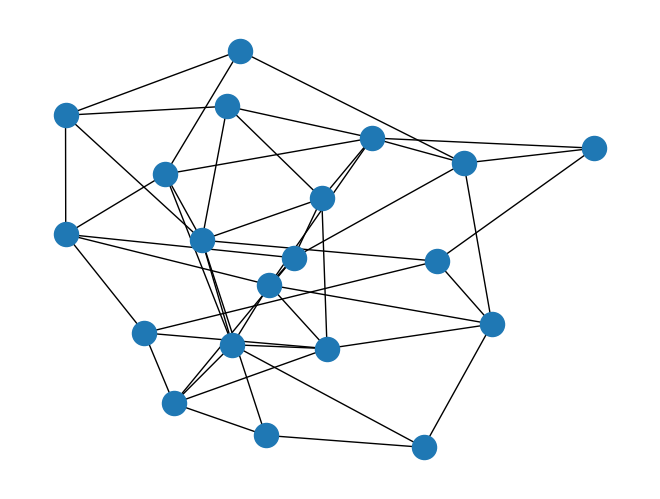

AttributeError: 'QueensOpt' object has no attribute 'source_graph'

In [46]:
nx.draw(problem.source_graph,
        pos=nx.spring_layout(problem.source_graph, seed = 1))
plt.show()



In [37]:
print(2 ** np.arange(11))

[   1    2    4    8   16   32   64  128  256  512 1024]


In [146]:
# create a runner class and solve the problem
hc = mlrose_hiive.RHCRunner(problem=problem,
              experiment_name='max_k_ga',
              output_directory=None, # note: specify an output directory to have results saved to disk
              seed=123456,
              iteration_list=2 ** np.arange(11),
              restart_list=[5,25,225])

# the two data frames will contain the results
df_run_stats_hc, df_run_curves_hc = hc.run()

In [152]:
print(len(df_run_curves_hc2))
print(len(df_run_curves_sa2))
print(len(df_run_curves_ga2))

25284
3075
8499


In [148]:
# create a runner class and solve the problem
hc2 = mlrose_hiive.RHCRunner(problem=problem2,
              experiment_name='queens',
              output_directory=None, # note: specify an output directory to have results saved to disk
              seed=123456,
              iteration_list=2 ** np.arange(11),
              restart_list=[5,25,225])

# the two data frames will contain the results
df_run_stats_hc2, df_run_curves_hc2 = hc2.run()

In [136]:
# create a runner class and solve the problem
sa = mlrose_hiive.SARunner(problem=problem,
              experiment_name='max_k_ga',
              output_directory=None, # note: specify an output directory to have results saved to disk
              seed=123456,
              iteration_list=2 ** np.arange(11),
              temperature_list=[.5,1,5])

# the two data frames will contain the results
df_run_stats_sa, df_run_curves_sa = sa.run()

In [149]:
# create a runner class and solve the problem
sa2 = mlrose_hiive.SARunner(problem=problem2,
              experiment_name='queens',
              output_directory=None, # note: specify an output directory to have results saved to disk
              seed=123456,
              iteration_list=2 ** np.arange(11),
              temperature_list=[.5,1,5])

# the two data frames will contain the results
df_run_stats_sa2, df_run_curves_sa2 = sa2.run()

In [140]:
# create a runner class and solve the problem
ga = mlrose_hiive.GARunner(problem=problem,
              experiment_name='max_k_ga',
              output_directory=None, # note: specify an output directory to have results saved to disk
              seed=123456,
              iteration_list=2 ** np.arange(11),
              population_sizes=[10, 20, 50],
              mutation_rates=[0.01, 0.05, 0.25])

# the two data frames will contain the results
df_run_stats_ga, df_run_curves_ga = ga.run()

In [150]:
# create a runner class and solve the problem
ga2 = mlrose_hiive.GARunner(problem=problem2,
              experiment_name='queens',
              output_directory=None, # note: specify an output directory to have results saved to disk
              seed=123456,
              iteration_list=2 ** np.arange(11),
              population_sizes=[10, 20, 50],
              mutation_rates=[0.01, 0.05, 0.25])

# the two data frames will contain the results
df_run_stats_ga2, df_run_curves_ga2 = ga2.run()

In [14]:
HTML(df_run_stats_ga[['Iteration', 'Fitness', 'FEvals', 'Time', 'State']][0:1].to_html())


,Iteration,Fitness,FEvals,Time,State
0,0,26.0,10,0.000266,"[1, 2, 2, 1, 0, 0, 0, 0, 2, 2, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2]"


In [15]:
HTML(df_run_stats_sa[['Iteration', 'Fitness', 'FEvals', 'Time', 'State']][0:1].to_html())

,Iteration,Fitness,FEvals,Time,State
0,0,26.0,0,0.000111,"[1, 2, 2, 1, 0, 0, 0, 0, 2, 2, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2]"


In [40]:
HTML(df_run_stats_hc[['Iteration', 'Fitness', 'FEvals', 'Time', 'State']][0:1].to_html())

,Iteration,Fitness,FEvals,Time,State
0,0,26.0,0,0.000489,"[1, 2, 2, 1, 0, 0, 0, 0, 2, 2, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2]"


In [17]:
HTML(df_run_stats_ga2[['Iteration', 'Fitness', 'FEvals', 'Time', 'State']][0:1].to_html())


,Iteration,Fitness,FEvals,Time,State
0,0,31.0,10,0.004928,"[1, 10, 18, 17, 11, 15, 11, 0, 4, 8, 10, 10, 12, 11, 11, 15, 18, 6, 2, 14]"


In [18]:
HTML(df_run_stats_sa2[['Iteration', 'Fitness', 'FEvals', 'Time', 'State']][0:1].to_html())

,Iteration,Fitness,FEvals,Time,State
0,0,31.0,0,0.000851,"[1, 10, 18, 17, 11, 15, 11, 0, 4, 8, 10, 10, 12, 11, 11, 15, 18, 6, 2, 14]"


In [41]:
HTML(df_run_stats_hc2[['Iteration', 'Fitness', 'FEvals', 'Time', 'State']][0:1].to_html())

,Iteration,Fitness,FEvals,Time,State
0,0,31.0,0,0.001381,"[1, 10, 18, 17, 11, 15, 11, 0, 4, 8, 10, 10, 12, 11, 11, 15, 18, 6, 2, 14]"


In [142]:
def custom_graph(best_fitness):
    bar = plt.bar(best_fitness.index, [int(i) for i in best_fitness['Percentage of results']], label="Bars 1", color="black")

    for rect in bar:
        height = rect.get_height()
        if height != 0:
            plt.text(rect.get_x() + rect.get_width() / 2.0, height, f'{height:.0f}', ha='center', va='bottom')
    plt.xlabel('Fitness')
    plt.ylabel('Percentage of results (%)')
    plt.show()
    return

def custom_graph_cumulative(best_fitness):
    new_y = []
    temp = 0
    for i in range(len(best_fitness['Percentage of results'].to_list())):
        temp += float(best_fitness['Percentage of results'].to_list()[i])
        new_y.append(int(temp))

    bar = plt.bar(best_fitness.index, new_y, label="Bars 1", color="black")

    for rect in bar:
        height = rect.get_height()
        if height != 0:
            plt.text(rect.get_x() + rect.get_width() / 2.0, height, f'{height:.0f}', ha='center', va='bottom')
    plt.xlabel('Fitness')
    plt.ylabel('Cumulative percentage of results (%)')
    plt.show()

         Percentage of results
Fitness                       
29.0                  0.007910
31.0                  0.011865
32.0                  0.043506
33.0                  0.039551
34.0                  0.142383
35.0                  0.213574
36.0                  0.090967
37.0                  0.201709
38.0                  0.217529
39.0                  0.138427
40.0                  0.352001
41.0                  0.462743
42.0                  0.783104
43.0                  0.597216
44.0                  0.767284
45.0                  0.794969
46.0                  2.819965
47.0                  3.338079
48.0                  4.908242
49.0                 16.500554
50.0                 15.737225
51.0                 35.880399
52.0                 11.908717
53.0                  4.034172
54.0                  0.007910


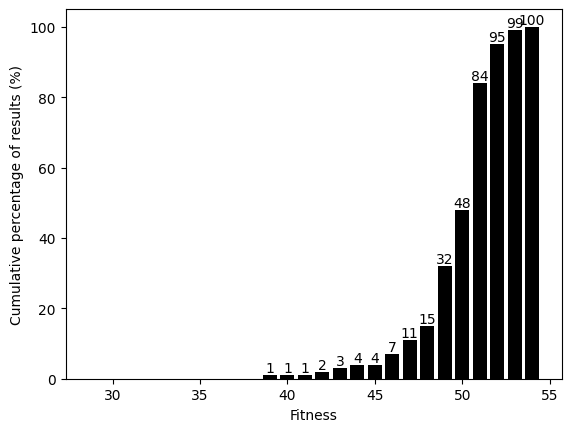

         Percentage of results
Fitness                       
31.0                  0.097561
32.0                  0.130081
33.0                  0.097561
34.0                  0.065041
35.0                  0.390244
36.0                  0.227642
37.0                  0.617886
38.0                  0.617886
39.0                  1.040650
40.0                  1.398374
41.0                  2.178862
42.0                  1.333333
43.0                  1.593496
44.0                  1.268293
45.0                  1.528455
46.0                  0.975610
47.0                  0.715447
48.0                  6.569106
49.0                  1.300813
50.0                  7.414634
51.0                 10.341463
52.0                 26.894309
53.0                 33.203252


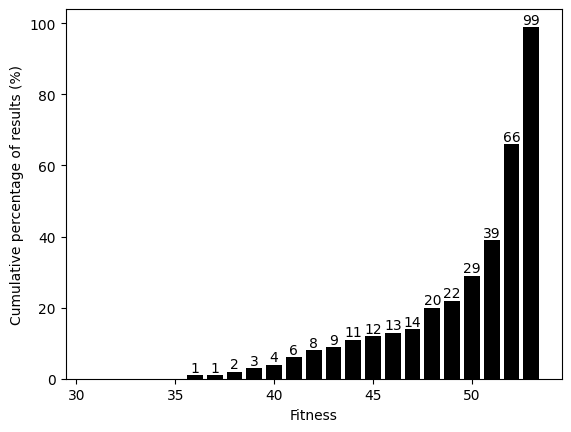

         Percentage of results
Fitness                       
31.0                  0.105895
41.0                  0.282386
42.0                  0.070597
43.0                  0.270620
44.0                  0.388281
45.0                  1.635487
46.0                  2.635604
47.0                  8.130368
48.0                  9.495235
49.0                 11.118955
50.0                 11.566067
51.0                 13.448641
52.0                 26.332510
53.0                 14.519355


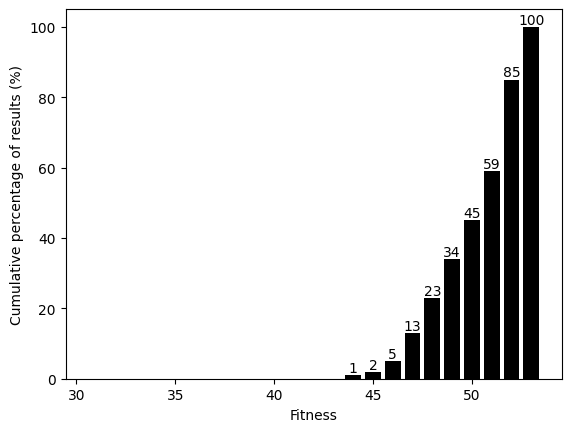

In [153]:
df_run_curves_hc2['Percentage of results'] = 1/len(df_run_curves_hc2.index) * 100
df_run_curves_sa2['Percentage of results'] = 1/len(df_run_curves_sa2.index) * 100
df_run_curves_ga2['Percentage of results'] = 1/len(df_run_curves_ga2.index) * 100


best_fitness_hc = df_run_curves_hc2[['Percentage of results','Fitness']].groupby(['Fitness'], sort=True).sum()
print(best_fitness_hc)
custom_graph_cumulative(best_fitness_hc)

best_fitness_sa = df_run_curves_sa2[['Percentage of results','Fitness']].groupby(['Fitness'], sort=True).sum()
print(best_fitness_sa)
custom_graph_cumulative(best_fitness_sa)

best_fitness_ga = df_run_curves_ga2[['Percentage of results','Fitness']].groupby(['Fitness'], sort=True).sum()
print(best_fitness_ga)
custom_graph_cumulative(best_fitness_ga)


#best_runs = df_run_curves_ga[df_run_curves_ga['Fitness'] == best_fitness]

In [66]:
best_fitness = df_run_curves_ga['Fitness'].min()
best_runs = df_run_curves_ga[df_run_curves_ga['Fitness'] == best_fitness]

HTML(best_runs.to_html())

,Iteration,Time,Fitness,FEvals,Population Size,Mutation Rate,max_iters
0,0,0.001068,26.0,10.0,10,0.1,1024
867,0,0.001068,26.0,10.0,10,0.2,1024
1647,0,0.001068,26.0,10.0,10,0.5,1024
2598,0,0.001068,26.0,20.0,20,0.1,1024
2692,0,0.001068,26.0,20.0,20,0.2,1024
3389,0,0.001068,26.0,20.0,20,0.5,1024
3559,0,0.001068,26.0,50.0,50,0.1,1024
3626,0,0.001068,26.0,50.0,50,0.2,1024
3685,0,0.001068,26.0,50.0,50,0.5,1024


## All three 2

In [125]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder

In [155]:
# Load and Split data into training and test sets
data = load_iris()
X_train3, X_test3, y_train3, y_test3 = train_test_split(
    data.data, data.target, test_size = 0.3, random_state = 123456
)

# Normalize feature data
scaler = MinMaxScaler()
X_train_scaled3 = scaler.fit_transform(X_train3)
X_test_scaled3 = scaler.transform(X_test3)

# One hot encode target values
one_hot = OneHotEncoder()
y_train_hot3 = one_hot.fit_transform(y_train3.reshape(-1, 1)).todense()
y_test_hot3 = one_hot.transform(y_test3.reshape(-1, 1)).todense()

In [156]:
# create a runner class and solve the problem
ga = mlrose_hiive.GARunner(x_train=X_train_scaled3,
        y_train=y_train_hot3,
        x_test=X_test_scaled3,
        y_test=y_test_hot3,
              experiment_name='iris_ga',
              output_directory=None, # note: specify an output directory to have results saved to disk
              seed=123456,
              iteration_list=2 ** np.arange(11),
              population_sizes=[10, 20, 50],
              mutation_rates=[0.1, 0.2, 0.5])

# the two data frames will contain the results
df_run_stats, df_run_curves = ga.run()

TypeError: GARunner.__init__() missing 1 required positional argument: 'problem'

## Hill Climb

In [148]:
def nn_custom_graph(model):    
    try:
        plt.plot(model.fitness_curve[:,0])
    except:
        plt.plot(model.fitness_curve)
    plt.xlabel('Iteration')
    plt.ylabel('Fitness')
    plt.show()
    return

In [186]:
# Initialize neural network object and fit object - attempt 1
nn_model_rh = mlrose_hiive.NeuralNetwork(hidden_nodes = [100], activation ='relu', 
                                 algorithm ='random_hill_climb', 
                                 max_iters = 1000, bias = False, is_classifier = True, 
                                 learning_rate = 0.001, early_stopping = True, 
                                 clip_max = 5, max_attempts = 1000, random_state = 3, curve=True)

nn_model_rh.fit(X_train2, Y_train2)

NeuralNetwork(bias=False, clip_max=5, curve=True, early_stopping=True,
              hidden_nodes=[100], learning_rate=0.001, max_attempts=1000,
              max_iters=1000, random_state=3)

In [187]:
# Predict labels for train set and assess accuracy
Y_train_pred_rh = nn_model_rh.predict(X_train2)
Y_train_accuracy_rh = sklearn.metrics.accuracy_score(Y_train2, Y_train_pred_rh)
print(Y_train_accuracy_rh)

Y_val_pred_rh = nn_model_rh.predict(X_val2)
Y_val_accuracy_rh = sklearn.metrics.accuracy_score(Y_val2, Y_val_pred_rh)
print(Y_val_accuracy_rh)

0.4623015873015873
0.512


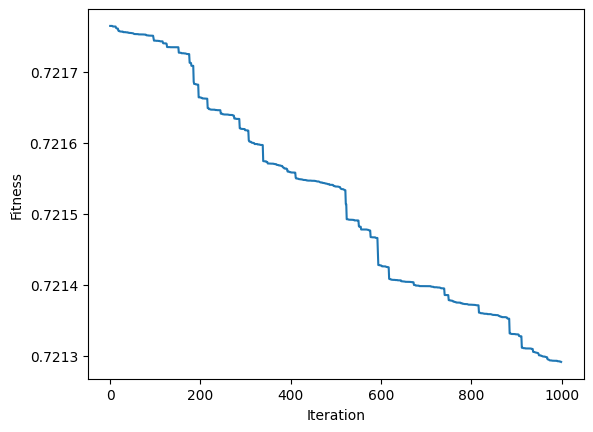

In [188]:
nn_custom_graph(nn_model_rh)

In [179]:
# Initialize neural network object and fit object - attempt 2
nn_model_gd = mlrose_hiive.NeuralNetwork(hidden_nodes = [100], activation = 'relu', 
                                 algorithm = 'gradient_descent', 
                                 max_iters = 100, bias = True, is_classifier = True, 
                                 learning_rate = 0.0001, early_stopping = True, 
                                 clip_max = 5, max_attempts = 100, random_state = 3, curve = True)

nn_model_gd.fit(X_train2, Y_train2)

NeuralNetwork(algorithm='gradient_descent', clip_max=5, curve=True,
              early_stopping=True, hidden_nodes=[100], learning_rate=0.0001,
              max_attempts=100, random_state=3)

In [180]:
# Predict labels for train set and assess accuracy
Y_train_pred_gd = nn_model_gd.predict(X_train2)
Y_train_accuracy_gd = sklearn.metrics.accuracy_score(Y_train2, Y_train_pred_gd)
print(Y_train_accuracy_gd)

Y_val_pred_gd = nn_model_gd.predict(X_val2)
Y_val_accuracy_gd = sklearn.metrics.accuracy_score(Y_val2, Y_val_pred_gd)
print(Y_val_accuracy_gd)

0.5714285714285714
0.528


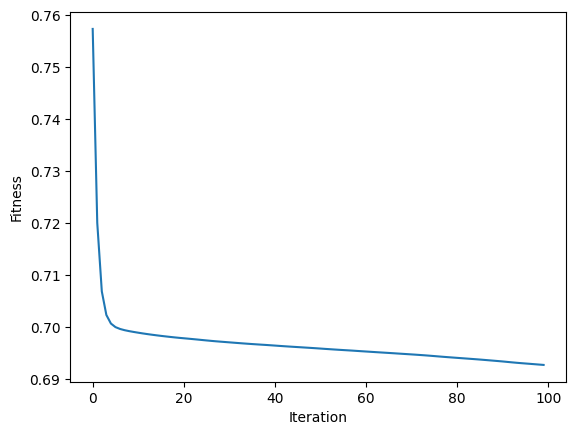

In [181]:
nn_custom_graph(nn_model_gd)

## Simmulated Annealing

In [203]:
# Initialize neural network object and fit object - attempt 1
nn_model_sa = mlrose_hiive.NeuralNetwork(hidden_nodes = [100], activation ='relu', 
                                 algorithm ='simulated_annealing', 
                                 max_iters = 100, bias = True, is_classifier = True, 
                                 learning_rate = 0.001, early_stopping = True, 
                                 clip_max = 5, max_attempts = 1000, random_state = 3, curve = True)

nn_model_sa.fit(X_train2, Y_train2)

NeuralNetwork(algorithm='simulated_annealing', clip_max=5, curve=True,
              early_stopping=True, hidden_nodes=[100], learning_rate=0.001,
              max_attempts=1000, random_state=3)

In [204]:
# Predict labels for train set and assess accuracy
Y_train_pred_sa = nn_model_sa.predict(X_train2)
Y_train_accuracy_sa = sklearn.metrics.accuracy_score(Y_train2, Y_train_pred_sa)
print(Y_train_accuracy_sa)

Y_val_pred_sa = nn_model_sa.predict(X_val2)
Y_val_accuracy_sa = sklearn.metrics.accuracy_score(Y_val2, Y_val_pred_sa)
print(Y_val_accuracy_sa)

0.4861111111111111
0.504


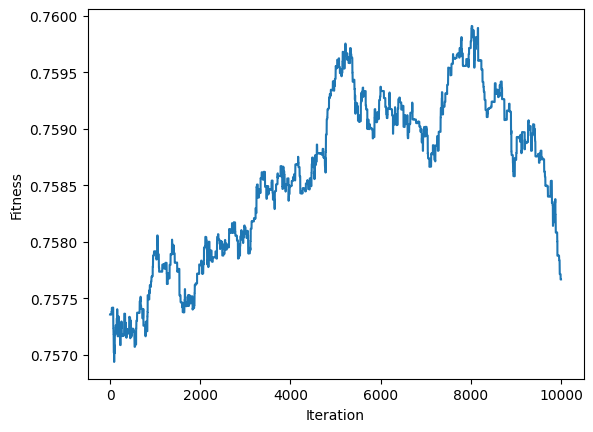

In [195]:
nn_custom_graph(nn_model_sa)

## Genetic Algorithm

In [211]:
# Initialize neural network object and fit object - attempt 1
nn_model_ga = mlrose_hiive.NeuralNetwork(hidden_nodes = [100], activation ='relu', 
                                 algorithm ='genetic_alg', 
                                 max_iters = 100, bias = True, is_classifier = True, 
                                 learning_rate = 0.001, early_stopping = True, 
                                 clip_max = 5, max_attempts = 100, random_state = 3, curve = True)

nn_model_ga.fit(X_train2, Y_train2)

NeuralNetwork(algorithm='genetic_alg', clip_max=5, curve=True,
              early_stopping=True, hidden_nodes=[100], learning_rate=0.001,
              max_attempts=100, random_state=3)

In [212]:
# Predict labels for train set and assess accuracy
Y_train_pred_ga = nn_model_ga.predict(X_train2)
Y_train_accuracy_ga = sklearn.metrics.accuracy_score(Y_train2, Y_train_pred_ga)
print(Y_train_accuracy_ga)

Y_val_pred_ga = nn_model_ga.predict(X_val2)
Y_val_accuracy_ga = sklearn.metrics.accuracy_score(Y_val2, Y_val_pred_ga)
print(Y_val_accuracy_ga)

0.5674603174603174
0.492


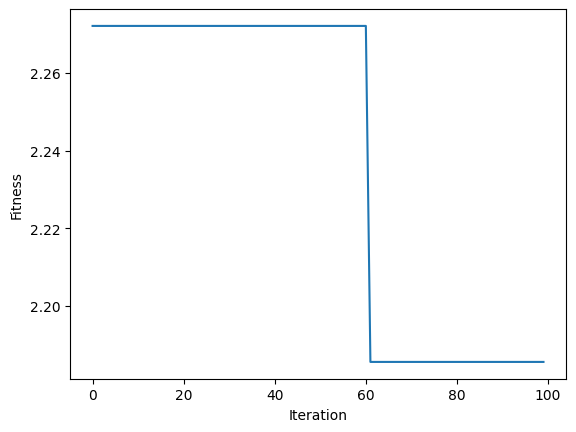

In [213]:
nn_custom_graph(nn_model_ga)

## SVM

In [29]:
def few_trials(variables = [], function_parameters = {}):
    #len(kernel_n_settings['settings'][1])
    new_parameter = variables.pop(0)
    
    new_function_parameters = {}
    
    if len(function_parameters.keys())>0:
        for key in function_parameters.keys():
            new_function_parameters[key] = []
            
        new_function_parameters[new_parameter] = []
        for i in range(len(function_parameters[list(function_parameters.keys())[0]])):
            if new_parameter == 'degree':
                for j in range(2,12):
                    for k in function_parameters.keys():
                        new_function_parameters[k].append(function_parameters[k][i])
                    new_function_parameters[new_parameter].append(j)
            else:
                for j in range(1,101,10):
                    for k in function_parameters.keys():
                        new_function_parameters[k].append(function_parameters[k][i])
                    new_function_parameters[new_parameter].append(j)
    #if old_function_parameters is empty
    else:
        new_function_parameters[new_parameter] = []
        if new_parameter == 'degree':
            for j in range(2,12):
                new_function_parameters[new_parameter].append(j)
        else:
            for j in range(1,101,10):
                new_function_parameters[new_parameter].append(j)

    
        
    if variables != []:
        new_function_parameters = few_trials(variables = variables, function_parameters = new_function_parameters)
    
    return new_function_parameters

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy of linear SVM: 0.5694444444444444


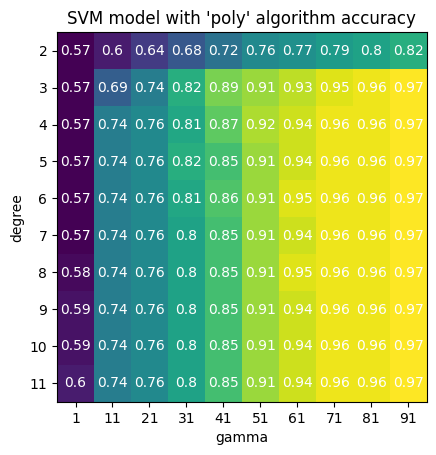

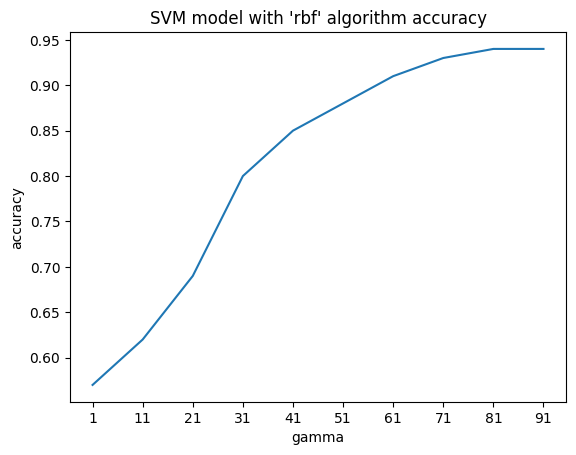

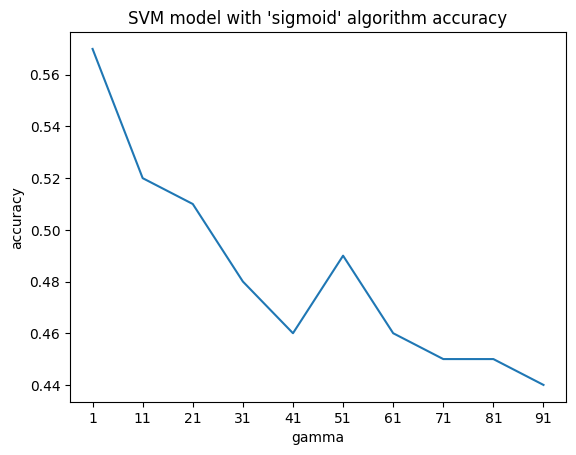

In [46]:
temp_X_train = X_train2
temp_Y_train = Y_train2
temp_X_val = X_val2
temp_Y_val = Y_val2

plot_location = '/plots2/'

# kernel_n_settings = {'kernels': ['linear','poly','rbf','sigmoid'], 'settings': [{},{'degree':30, 'gamma':2},{'gamma':10},{'gamma':50}]}
# for k_i, kern in enumerate(kernel_n_settings['kernels']):
#     # Fit the SVM model
#     model = svm.SVC(kernel=kern, **kernel_n_settings['settings'][k_i])

#     model.fit(temp_X_train, temp_Y_train)
#     # Predict using the SVM model
#     predictions = model.predict(temp_X_val)

#     # Evaluate the predictions
#     accuracy = model.score(temp_X_val, temp_Y_val)
#     print(f"Accuracy of SVM: {kern}", accuracy)


kernel_n_settings = {'kernels': ['linear','poly','rbf','sigmoid'], 'settings': [[],['degree', 'gamma'],['gamma'],['gamma']]}
for k_i, kern in enumerate(kernel_n_settings['kernels']):

    if len(kernel_n_settings['settings'][k_i])!=0:
        new_function_parameters = few_trials(variables = kernel_n_settings['settings'][k_i], function_parameters={})
    else:
        new_function_parameters = {}
    
    result_tracker = []
    if len(new_function_parameters.values())!=0: 
        for p_i in range(len(list(new_function_parameters.values())[0])):
            
            temp_func_parameters = {k:v[p_i] for k,v in new_function_parameters.items()}
            
            # Fit the SVM model
            model = svm.SVC(kernel=kern, **temp_func_parameters)

            model.fit(temp_X_train, np.squeeze(np.array(temp_Y_train)))
            # Predict using the SVM model
            predictions = model.predict(temp_X_val)

            # Evaluate the predictions
            accuracy = model.score(temp_X_val, np.squeeze(np.array(temp_Y_val)))
            if p_i%10==0:
                result_tracker.append([])
                result_tracker[-1].append(round(accuracy,2))
            else:
                result_tracker[-1].append(round(accuracy,2))
            #print(f"Accuracy of {kern} SVM: {temp_func_parameters}", accuracy)
        
        
        if len(new_function_parameters.values())==2:
            plt.imshow(result_tracker,interpolation='none')
            plt.title(f'SVM model with \'{kern}\' algorithm accuracy')

            # Loop over data dimensions and create text annotations.
            for i in range(len(result_tracker)):
                for j in range(len(result_tracker[i])):
                    text = plt.text(j, i, result_tracker[i][j],
                                   ha="center", va="center", color="w")

            # Show all ticks and label them with the respective list entries
            plt.yticks(np.arange(len(range(2,12))), labels=range(2,12))
            plt.xticks(np.arange(len(range(1,101,10))), labels=range(1,101,10))
            plt.ylabel('degree')
            plt.xlabel('gamma')
            plt.savefig(cwd+f'{plot_location}SVM_{kern}.png')
            plt.show()
        else:
            plt.plot(result_tracker[0])
            plt.title(f'SVM model with \'{kern}\' algorithm accuracy')
            plt.xticks(range(len(new_function_parameters['gamma'])), new_function_parameters['gamma'])
            plt.ylabel('accuracy')
            plt.xlabel('gamma')
            plt.savefig(cwd+f'{plot_location}SVM_{kern}.png')
            plt.show()
        
    else:
        # Fit the SVM model
        model = svm.SVC(kernel=kern)

        model.fit(temp_X_train, temp_Y_train)
        # Predict using the SVM model
        predictions = model.predict(temp_X_val)

        # Evaluate the predictions
        accuracy = model.score(temp_X_val, temp_Y_val)
        print(f"Accuracy of {kern} SVM:", accuracy)
    
    #print(result_tracker)

# #KNN

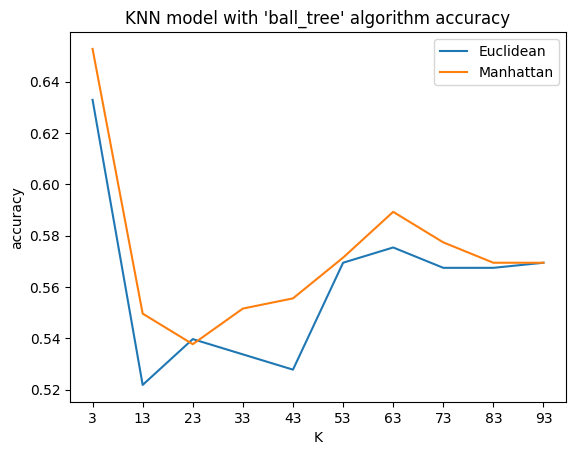

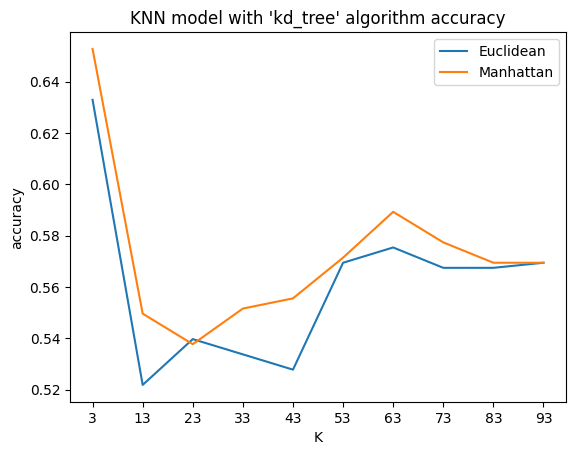

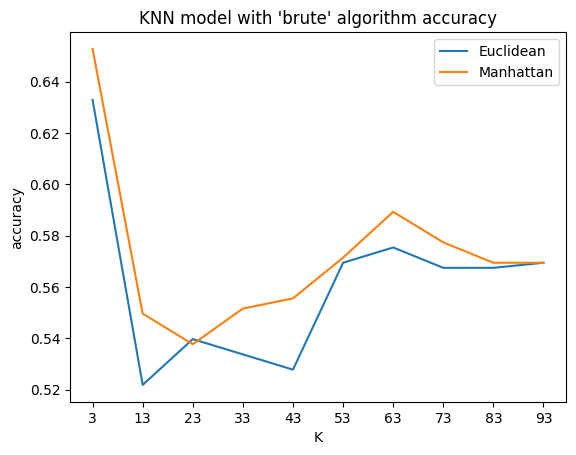

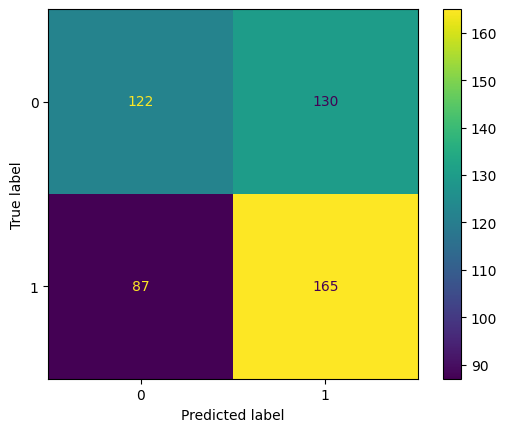

In [47]:


best_result = {'accuracy': 0, 'algo': 'auto', 'p': 1, 'K': 1}
for algo in ['ball_tree', 'kd_tree', 'brute']:
    result_tracker = {1:[], 2:[]}
    for p in [1,2]:
        ran = range(3,100,10)
        for n_neighbors in ran:        
            neigh = KNeighborsClassifier(n_neighbors=n_neighbors, algorithm = algo, p=p)
            neigh.fit(temp_X_train, np.squeeze(np.array(temp_Y_train)))


            # Evaluate the predictions
            accuracy = neigh.score(temp_X_val, np.squeeze(np.array(temp_Y_val)))
            pred_y = neigh.predict(temp_X_val)
            #print(f"Accuracy of KNN({n_neighbors}) {algo} {p}:", accuracy)
            result_tracker[p].append(accuracy)
            
            if accuracy > best_result['accuracy']:
                best_result = {'accuracy': accuracy, 'algo': algo, 'p': p, 'K': n_neighbors}
    plt.plot(result_tracker[1])
    plt.xticks(range(len(ran)), ran)
    plt.plot(result_tracker[2])
    plt.title(f'KNN model with \'{algo}\' algorithm accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('K')
    plt.legend(['Euclidean', 'Manhattan'], loc='upper right')
    plt.savefig(cwd+f'{plot_location}KNN_{algo}.png')
    plt.show()



cm = sklearn.metrics.confusion_matrix(temp_Y_val, pred_y, labels=neigh.classes_)
disp = sklearn.metrics.ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=neigh.classes_)
disp.plot()
plt.show()

In [48]:
print(best_result)

{'accuracy': 0.6527777777777778, 'algo': 'ball_tree', 'p': 2, 'K': 3}


Accuracy of KNN based on number of features: 0.5
Accuracy of KNN based on number of features: 0.7936507936507936
Accuracy of KNN based on number of features: 0.75
Accuracy of KNN based on number of features: 0.7321428571428571
Accuracy of KNN based on number of features: 0.75
Accuracy of KNN based on number of features: 0.7281746031746031
Accuracy of KNN based on number of features: 0.7202380952380952
Accuracy of KNN based on number of features: 0.7301587301587301
Accuracy of KNN based on number of features: 0.7380952380952381
Accuracy of KNN based on number of features: 0.7142857142857143
Accuracy of KNN based on number of features: 0.7103174603174603
Accuracy of KNN based on number of features: 0.7063492063492064
Accuracy of KNN based on number of features: 0.7103174603174603
Accuracy of KNN based on number of features: 0.7083333333333334
Accuracy of KNN based on number of features: 0.7043650793650794
Accuracy of KNN based on number of features: 0.6845238095238095
Accuracy of KNN bas

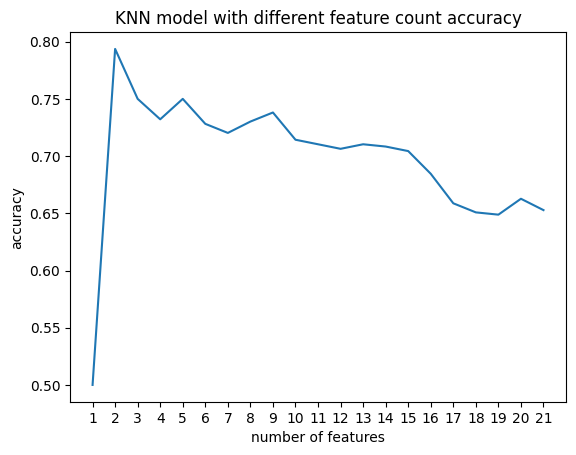

In [49]:


result_tracker2 = []
best_result2 = {}
for num_features in range(1,len(temp_X_train.columns)+1):
    tempT_X_train = temp_X_train.loc[:,temp_X_train.columns.isin(temp_X_train.columns[0:num_features])]
    tempT_X_val = temp_X_val.loc[:,temp_X_val.columns.isin(temp_X_val.columns[0:num_features])]
    
    neigh = KNeighborsClassifier(n_neighbors=best_result['K'], algorithm = best_result['algo'], p=best_result['p'])
    neigh.fit(tempT_X_train, np.squeeze(np.array(temp_Y_train)))


    # Evaluate the predictions
    accuracy = neigh.score(tempT_X_val, np.squeeze(np.array(temp_Y_val)))
    pred_y = neigh.predict(tempT_X_val)
    print(f"Accuracy of KNN based on number of features:", accuracy)
    result_tracker2.append(accuracy)
    
    
plt.plot(result_tracker2)

plt.title(f'KNN model with different feature count accuracy')
plt.xticks(range(len(temp_X_train.columns)), range(1,len(temp_X_train.columns)+1))
plt.ylabel('accuracy')
plt.xlabel('number of features')
print(algo)
plt.savefig(cwd+f'{plot_location}KNN_{algo}_feature.png')
plt.show()

## Neural Network

In [ ]:
def initialize_inception_model():
    x_input = tf.keras.Input(shape=(20,1))
    conv_1 = tf.keras.layers.Conv1D(filters=15,kernel_size=7,strides=1,activation=tf.keras.layers.ReLU(),input_shape=(20,1))(x_input)
    conv_1 = tf.keras.layers.Conv1D(filters=15,kernel_size=7,strides=1,activation=tf.keras.layers.ReLU(),input_shape=(20,1))(x_input)
    conv_1 = tf.expand_dims(x_input,-1)
    conv_2a = tf.keras.layers.Conv2D(filters=10,kernel_size=1,padding='same',strides=1,activation=tf.keras.layers.ReLU(),input_shape=conv_1.shape)(conv_1)
    conv_2b1 = tf.keras.layers.Conv2D(filters=10,kernel_size=1,padding='same',strides=1,activation=tf.keras.layers.ReLU(),input_shape=conv_1.shape)(conv_1)
    conv_2b2 = tf.keras.layers.Conv2D(filters=10,kernel_size=3,padding='same',strides=1,activation=tf.keras.layers.ReLU(),input_shape=conv_1.shape)(conv_2b1)
    conv_2c1 = tf.keras.layers.Conv2D(filters=10,kernel_size=1,padding='same',strides=1,activation=tf.keras.layers.ReLU(),input_shape=conv_1.shape)(conv_1)
    conv_2c2 = tf.keras.layers.Conv2D(filters=10,kernel_size=5,padding='same',strides=1,activation=tf.keras.layers.ReLU(),input_shape=conv_1.shape)(conv_2c1)
    conv_2d1 = tf.keras.layers.Conv2D(filters=10,kernel_size=1,padding='same',strides=1,activation=tf.keras.layers.ReLU(),input_shape=conv_1.shape)(conv_1)
    conv_2d2 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2),padding='same',strides=1)(conv_2d1)
    concat_2 = tf.keras.layers.Concatenate(axis=1)([conv_2a,conv_2b2,conv_2c2,conv_2d2])
    conv_3a = tf.keras.layers.Conv2D(filters=10,kernel_size=1,padding='same',strides=1,activation=tf.keras.layers.ReLU(),input_shape=conv_1.shape)(concat_2)
    conv_3b1 = tf.keras.layers.Conv2D(filters=10,kernel_size=1,padding='same',strides=1,activation=tf.keras.layers.ReLU(),input_shape=conv_1.shape)(concat_2)
    conv_3b2 = tf.keras.layers.Conv2D(filters=10,kernel_size=3,padding='same',strides=1,activation=tf.keras.layers.ReLU(),input_shape=conv_1.shape)(conv_3b1)
    conv_3c1 = tf.keras.layers.Conv2D(filters=10,kernel_size=1,padding='same',strides=1,activation=tf.keras.layers.ReLU(),input_shape=conv_1.shape)(concat_2)
    conv_3c2 = tf.keras.layers.Conv2D(filters=10,kernel_size=5,padding='same',strides=1,activation=tf.keras.layers.ReLU(),input_shape=conv_1.shape)(conv_3c1)
    conv_3d1 = tf.keras.layers.Conv2D(filters=10,kernel_size=1,padding='same',strides=1,activation=tf.keras.layers.ReLU(),input_shape=conv_1.shape)(concat_2)
    conv_3d2 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2),padding='same',strides=1)(conv_2d1)
    concat_3 = tf.keras.layers.Concatenate(axis=1)([conv_2a,conv_3a,conv_3b2,conv_3c2,conv_3d2,concat_2])
    output = tf.keras.layers.Flatten()(concat_3)
    output = tf.keras.layers.Dropout(.21)(output)
    output = tf.keras.layers.Dense(30, activation=tf.keras.layers.ReLU())(output)
    output = tf.keras.layers.Dropout(.21)(output)
    output = tf.keras.layers.Dense(1, activation='sigmoid')(output)
    print(conv_2a.shape)
    print(conv_2b2.shape)
    print(conv_2c2.shape)
    print(conv_2d2.shape)
    print(concat_2.shape)
      
    return tf.keras.Model(inputs = x_input, outputs = output)

    

In [56]:
model = initialize_inception_model()
#tf.keras.optimizers.legacy.Adam(learning_rate=0.1)
#tf.keras.optimizers.legacy.SGD(learning_rate = .001, clipvalue=10000)
model.compile(tf.keras.optimizers.legacy.Adam(learning_rate=0.000001), loss='binary_crossentropy', metrics=['accuracy'])
hist = model.fit(testing1_ds.batch(4096), validation_data = testing2_ds.batch(4096), epochs=10, verbose=1)

(None, 20, 1, 10)
(None, 20, 1, 10)
(None, 20, 1, 10)
(None, 20, 1, 10)
(None, 80, 1, 10)
Epoch 1/10
1/1 [==============================] - 0s 409ms/step - loss: 0.6927 - accuracy: 0.5317 - val_loss: 0.6931 - val_accuracy: 0.5119
Epoch 2/10
1/1 [==============================] - 0s 25ms/step - loss: 0.6931 - accuracy: 0.5079 - val_loss: 0.6931 - val_accuracy: 0.5119
Epoch 3/10
1/1 [==============================] - 0s 26ms/step - loss: 0.6931 - accuracy: 0.5079 - val_loss: 0.6931 - val_accuracy: 0.5119
Epoch 4/10
1/1 [==============================] - 0s 24ms/step - loss: 0.6930 - accuracy: 0.5437 - val_loss: 0.6931 - val_accuracy: 0.5119
Epoch 5/10
1/1 [==============================] - 0s 25ms/step - loss: 0.6931 - accuracy: 0.4881 - val_loss: 0.6931 - val_accuracy: 0.5119
Epoch 6/10
1/1 [==============================] - 0s 25ms/step - loss: 0.6931 - accuracy: 0.4881 - val_loss: 0.6931 - val_accuracy: 0.5119
Epoch 7/10
1/1 [==============================] - 0s 25ms/step - loss: 0.69

# STOP

In [37]:
#for p in training_ds.take(1):
#    print(p)
#for p in testing_ds.batch(1024).take(1):
#    print(p[1])

(<tf.Tensor: shape=(20,), dtype=float64, numpy=
array([ 0.00816041,  0.00327485,  0.00611909,  0.02237729, -0.01981132,
       -0.00749064, -0.01407801,  0.00533643,  0.01603017, -0.01095827,
       -0.01152339,  0.00509613, -0.0199773 , -0.00451977, -0.03024326,
       -0.02873563, -0.00381679, -0.03833605, -0.02135302,  0.01581188])>, <tf.Tensor: shape=(1,), dtype=float64, numpy=array([-0.04024052])>)
tf.Tensor(
[[ 0.00750983]
 [-0.01609087]
 [ 0.00300625]
 ...
 [ 0.02263648]
 [-0.05989583]
 [-0.04016621]], shape=(1024, 1), dtype=float64)


In [112]:
class PrecisionCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        train_loss = logs.get('loss')
        train_mae = logs.get('mae')
        val_loss = logs.get('val_loss')
        val_mae = logs.get('val_mae')

        if train_loss is not None and train_mae is not None and val_loss is not None and val_mae is not None:
            print(f'Epoch {epoch + 1}: '
                  f'train_loss: {train_loss:.5f}, '
                  f'train_mae: {train_mae:.5f}, '
                  f'val_loss: {val_loss:.5f}, '
                  f'val_mae: {val_mae:.5f}')

In [21]:
def evaluate_model(model, model_inputs):
    model.evaluate(model_inputs.loc[:,~model_inputs.columns.isin(['t0_-10','t0_-1','date','tickers'])].astype(np.float64),model_inputs.loc[:,model_inputs.columns.isin(['t0_-10','t0_-1'])].astype(np.float64))

## MODELS

In [52]:
def initialize_inception_model():
    x_input = tf.keras.Input(shape=(20,1))
    conv_1 = tf.keras.layers.Conv1D(filters=15,kernel_size=7,strides=1,activation=tf.keras.layers.ReLU(),input_shape=(20,1))(x_input)
    conv_1 = tf.keras.layers.Conv1D(filters=15,kernel_size=7,strides=1,activation=tf.keras.layers.ReLU(),input_shape=(20,1))(x_input)
    conv_1 = tf.expand_dims(x_input,-1)
    conv_2a = tf.keras.layers.Conv2D(filters=10,kernel_size=1,padding='same',strides=1,activation=tf.keras.layers.ReLU(),input_shape=conv_1.shape)(conv_1)
    conv_2b1 = tf.keras.layers.Conv2D(filters=10,kernel_size=1,padding='same',strides=1,activation=tf.keras.layers.ReLU(),input_shape=conv_1.shape)(conv_1)
    conv_2b2 = tf.keras.layers.Conv2D(filters=10,kernel_size=3,padding='same',strides=1,activation=tf.keras.layers.ReLU(),input_shape=conv_1.shape)(conv_2b1)
    conv_2c1 = tf.keras.layers.Conv2D(filters=10,kernel_size=1,padding='same',strides=1,activation=tf.keras.layers.ReLU(),input_shape=conv_1.shape)(conv_1)
    conv_2c2 = tf.keras.layers.Conv2D(filters=10,kernel_size=5,padding='same',strides=1,activation=tf.keras.layers.ReLU(),input_shape=conv_1.shape)(conv_2c1)
    conv_2d1 = tf.keras.layers.Conv2D(filters=10,kernel_size=1,padding='same',strides=1,activation=tf.keras.layers.ReLU(),input_shape=conv_1.shape)(conv_1)
    conv_2d2 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2),padding='same',strides=1)(conv_2d1)
    concat_2 = tf.keras.layers.Concatenate(axis=1)([conv_2a,conv_2b2,conv_2c2,conv_2d2])
    conv_3a = tf.keras.layers.Conv2D(filters=10,kernel_size=1,padding='same',strides=1,activation=tf.keras.layers.ReLU(),input_shape=conv_1.shape)(concat_2)
    conv_3b1 = tf.keras.layers.Conv2D(filters=10,kernel_size=1,padding='same',strides=1,activation=tf.keras.layers.ReLU(),input_shape=conv_1.shape)(concat_2)
    conv_3b2 = tf.keras.layers.Conv2D(filters=10,kernel_size=3,padding='same',strides=1,activation=tf.keras.layers.ReLU(),input_shape=conv_1.shape)(conv_3b1)
    conv_3c1 = tf.keras.layers.Conv2D(filters=10,kernel_size=1,padding='same',strides=1,activation=tf.keras.layers.ReLU(),input_shape=conv_1.shape)(concat_2)
    conv_3c2 = tf.keras.layers.Conv2D(filters=10,kernel_size=5,padding='same',strides=1,activation=tf.keras.layers.ReLU(),input_shape=conv_1.shape)(conv_3c1)
    conv_3d1 = tf.keras.layers.Conv2D(filters=10,kernel_size=1,padding='same',strides=1,activation=tf.keras.layers.ReLU(),input_shape=conv_1.shape)(concat_2)
    conv_3d2 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2),padding='same',strides=1)(conv_2d1)
    concat_3 = tf.keras.layers.Concatenate(axis=1)([conv_2a,conv_3a,conv_3b2,conv_3c2,conv_3d2,concat_2])
    output = tf.keras.layers.Flatten()(concat_3)
    output = tf.keras.layers.Dropout(.21)(output)
    output = tf.keras.layers.Dense(30, activation=tf.keras.layers.ReLU())(output)
    output = tf.keras.layers.Dropout(.21)(output)
    output = tf.keras.layers.Dense(1, activation='sigmoid')(output)
    print(conv_2a.shape)
    print(conv_2b2.shape)
    print(conv_2c2.shape)
    print(conv_2d2.shape)
    print(concat_2.shape)
      
    return tf.keras.Model(inputs = x_input, outputs = output)

    

In [79]:
def initialize_model():
    x_input = tf.keras.Input(shape=(20,1))
    print(x_input.shape)
    #tf.keras.layers.LeakyReLU(alpha=0.2)
    #N, T, F
    conv_1 = tf.keras.layers.Conv1D(filters=30,kernel_size=5,strides=1,activation=tf.keras.layers.LeakyReLU(alpha=0.2),input_shape=(20,1))(x_input)
    print(conv_1.shape)
    conv_1 = tf.expand_dims(conv_1,-1)
    #N, W, H, C for Conv2D
    conv_2 = tf.keras.layers.Conv2D(filters=30,kernel_size=5,strides=1,activation=tf.keras.layers.LeakyReLU(alpha=0.2),input_shape=conv_1.shape)(conv_1)
    print(conv_2.shape)
    conv_3 = tf.keras.layers.Conv2D(filters=30,kernel_size=5,strides=1,activation=tf.keras.layers.LeakyReLU(alpha=0.2),input_shape=conv_2.shape[1:2])(conv_2)
    print(conv_3.shape)
    conv_4 = tf.keras.layers.Conv2D(filters=30,kernel_size=5,strides=1,activation=tf.keras.layers.LeakyReLU(alpha=0.2),input_shape=conv_3.shape[1:2])(conv_3)
    #conv_5 = tf.keras.layers.Conv2D(filters=20,kernel_size=3,strides=1,activation=tf.keras.layers.LeakyReLU(alpha=0.2),input_shape=conv_4.shape[1:2])(conv_4)
    #conv_6 = tf.keras.layers.Conv2D(filters=20,kernel_size=3,strides=1,activation=tf.keras.layers.LeakyReLU(alpha=0.2),input_shape=conv_5.shape[1:2])(conv_5)
    #conv_7 = tf.keras.layers.Conv2D(filters=20,kernel_size=3,strides=1,activation=tf.keras.layers.LeakyReLU(alpha=0.2),input_shape=conv_6.shape[1:2])(conv_6)
    print(conv_4.shape)
    output = tf.keras.layers.Flatten()(conv_3)
    output = tf.keras.layers.Dropout(.22)(output)
    output = tf.keras.layers.Dense(30, activation=tf.keras.layers.LeakyReLU(alpha=0.2))(output)
    output = tf.keras.layers.Dropout(.22)(output)
    output = tf.keras.layers.Dense(1, activation='linear')(output)
    print(output.shape)
    
    return tf.keras.Model(inputs = x_input, outputs = output)

model = initialize_model()
#tf.keras.optimizers.legacy.Adam(learning_rate=0.1)
#tf.keras.optimizers.legacy.SGD(learning_rate = .001, clipvalue=10000)
model.compile(tf.keras.optimizers.legacy.Adam(learning_rate=0.000001), loss='mse', metrics=['mae'])
#print(training_ds[0].shape)

(None, 20, 1)
(None, 16, 30)
(None, 12, 26, 30)
(None, 8, 22, 30)
(None, 4, 18, 30)
(None, 1)


In [ ]:
def positional_encoding(pos, d_model):
    def get_angles(position, i, d_model):
        angles = 1 / np.power(10000, (2 * (i // 2)) / np.float32(d_model))
        return position * angles

    angle_rads = get_angles(np.arange(pos)[:, np.newaxis],
                            np.arange(d_model)[np.newaxis, :],
                            d_model)

    sines = np.sin(angle_rads[:, 0::2])
    cosines = np.cos(angle_rads[:, 1::2])

    pos_encoding = np.concatenate([sines, cosines], axis=-1)
    pos_encoding = pos_encoding[np.newaxis, ...]

    return tf.cast(pos_encoding, dtype=tf.float32)


def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    x = tf.keras.layers.LayerNormalization(epsilon=1e-6)(inputs)
    x = tf.keras.layers.MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(x, x)
    x = tf.keras.layers.Add()([x, inputs])

    x = tf.keras.layers.LayerNormalization(epsilon=1e-6)(x)
    x = tf.keras.layers.Dense(ff_dim, activation="relu")(x)
    x = tf.keras.layers.Dropout(dropout)(x)
    x = tf.keras.layers.Dense(inputs.shape[-1])(x)
    x = tf.keras.layers.Add()([x, inputs])
    return x


inputs = tf.keras.layers.Input(shape=(20, 1))
#pos_encoding = positional_encoding(20, 32)  
x = inputs# + pos_encoding

x = transformer_encoder(x, head_size=256, num_heads=8, ff_dim=256, dropout=0.3)
x = transformer_encoder(x, head_size=256, num_heads=8, ff_dim=256, dropout=0.3)
x = transformer_encoder(x, head_size=256, num_heads=8, ff_dim=256, dropout=0.3)
x = transformer_encoder(x, head_size=256, num_heads=8, ff_dim=256, dropout=0.3)

x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dense(32, activation='relu')(x)
outputs = tf.keras.layers.Dense(1)(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
optim = tf.keras.optimizers.legacy.Adam(learning_rate=0.005)
model.compile(optimizer=optim, loss='mae', metrics=['mse'])


epochs = 10
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2)


model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath='non_m_10_model_epoch_{epoch:02d}.hdf5',
    save_freq='epoch',
    save_best_only=False,  
    save_weights_only=False,
    monitor='val_loss',
    verbose=1
)



history = model.fit(
    training_ds.batch(1024),
    epochs=epochs,
    validation_data=validation_ds.batch(1024),
    callbacks=[early_stopping, reduce_lr, model_checkpoint]  
)

Epoch 1/10
  649/12648 [>.............................] - ETA: 9:55:59 - loss: 0.0243 - mse: 0.0289

In [90]:
def initialize_LSTM_model():
    x_input = tf.keras.Input(shape=(20,1))
    lstm_1 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True), input_shape=x_input.shape)(x_input)
    lstm_2 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True), input_shape=lstm_1.shape)(lstm_1)
    lstm_3 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True), input_shape=lstm_2.shape)(lstm_2)
    #print(lstm_3.shape)
    output = tf.keras.layers.Dropout(.20)(lstm_3)
    output = tf.keras.layers.Dense(64)(output)
    output = tf.keras.layers.Dropout(.20)(output)
    output = tf.keras.layers.Dense(32)(output)
    output = tf.keras.layers.Dense(1)(output)
    print(output.shape)
    
    return tf.keras.Model(inputs = x_input, outputs = output)

In [91]:
model = initialize_LSTM_model()

(None, 20, 1)


In [92]:
model.compile(tf.keras.optimizers.Adam(learning_rate=0.000001), loss='mse', metrics=['mae'])

In [93]:
#hist = model.fit(training_ds.batch(4096), validation_data = validation_ds.batch(4096), epochs=10, verbose=1)

In [94]:
hist = model.fit(training_ds.batch(4096), validation_data = validation_ds.batch(4096), epochs=10, verbose=1)

Epoch 1/10
3162/3162 [==============================] - 1538s 485ms/step - loss: 0.0283 - mae: 0.0240 - val_loss: 0.0321 - val_mae: 0.0293
Epoch 2/10
3162/3162 [==============================] - ETA: 0s - loss: 0.0283 - mae: 0.0240

KeyboardInterrupt: 

In [64]:
name = 'LSTM32_br-LSTM32_br-drop20-d30'
model.save_weights(cwd+f'/checkpoints_noexploding2/{name}')

hist_df = pd.DataFrame(hist.history)
hist_json_file = cwd+'/histories2/'+f'{name}.json' 
with open(hist_json_file, mode='w') as f:
    hist_df.to_json(f)
    
print(model.summary())

NameError: name 'hist' is not defined

In [31]:
evaluate_model(model, testing1_df)
evaluate_model(model, testing2_df)

389/389 [==============================] - 1s 3ms/step - loss: 0.0154 - mse: 5.6789e-04


In [46]:
our_portfolio, average_portfolio = simulate_portfolio(model,testing2_df)
graph_portfoliocomparison_noncumulativereturns(our_portfolio, average_portfolio)

389/389 [==============================] - 2s 4ms/step


ValueError: Must pass 2-d input. shape=(1, 20, 1)

In [52]:
#model = tf.keras.models.load_model(cwd+f'/checkpoints_noexploding2/{name}.keras')

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_23 (InputLayer)       [(None, 20, 1)]              0         []                            
                                                                                                  
 tf.expand_dims_21 (TFOpLam  (None, 20, 1, 1)             0         ['input_23[0][0]']            
 bda)                                                                                             
                                                                                                  
 conv2d_104 (Conv2D)         (None, 20, 1, 10)            20        ['tf.expand_dims_21[0][0]']   
                                                                                                  
 conv2d_106 (Conv2D)         (None, 20, 1, 10)            20        ['tf.expand_dims_21[0][0

In [87]:
x_ = validation_df.loc[0::1000000,~validation_df.columns.isin(['date','tickers','t0_-1'])].astype(np.float64)
y_ = validation_df.loc[0::1000000,validation_df.columns.isin(['t0_-1'])]
#print(x_)

y_h = model.predict([x_])
print(y_h)
print(y_)

1/1 [==============================] - 1s 673ms/step
[[[ 1.78698159e-04]
  [ 7.86808232e-05]
  [-6.44687825e-05]
  [-1.36901959e-04]
  [-2.19791487e-04]
  [-2.17297173e-04]
  [-1.38856340e-04]
  [-3.02711815e-05]
  [-1.62269534e-05]
  [-4.67857317e-05]
  [-9.35334974e-05]
  [-1.17260388e-04]
  [-1.22781727e-04]
  [-1.09450317e-04]
  [-7.87325407e-05]
  [-3.53433497e-05]
  [ 2.51493730e-05]
  [ 8.34010571e-05]
  [ 9.34927011e-05]
  [ 8.18310364e-05]]

 [[ 8.60091604e-05]
  [ 9.64068022e-05]
  [ 1.04935651e-04]
  [ 1.11797402e-04]
  [ 1.17187912e-04]
  [ 1.21287361e-04]
  [ 1.24255021e-04]
  [ 1.26226674e-04]
  [ 1.27313455e-04]
  [ 1.27601699e-04]
  [ 1.27153005e-04]
  [ 1.26004190e-04]
  [ 1.24167345e-04]
  [ 1.21629448e-04]
  [ 1.18351352e-04]
  [ 1.14266571e-04]
  [ 1.09279266e-04]
  [ 1.03261948e-04]
  [ 9.60528632e-05]
  [ 8.74537218e-05]]

 [[-1.82313641e-04]
  [-2.58470944e-04]
  [-3.46336339e-04]
  [-5.39860048e-04]
  [-8.44717957e-04]
  [-1.25348475e-03]
  [-1.59297127e-03]
  [

In [49]:
model.evaluate(x_,y_)

1/1 [==============================] - 0s 11ms/step - loss: 4.7831e-05 - mae: 0.0069


[4.7831454139668494e-05, 0.0068623400293290615]

In [52]:
pred_v = np.array([[-0.00735895, -0.03624901, -0.02571977, -0.04368576,  0.01755697, -0.03042376,
  -0.00396825, -0.03144654,  0.02727925,  0.02426471, -0.00910747,  0.04135053,
  -0.01236418, -0.00706845,  0.11767152,  0.02166525,  0.02170139,  0.02536716,
  -0.05349621,  0.05090748],])
print(model.weights[0])
print((pred_v)[None,:,:].shape)
y_h = model.predict(pred_v)
print(y_h)

<tf.Variable 'conv1d_3/kernel:0' shape=(5, 1, 5) dtype=float32, numpy=
array([[[-0.2502947 , -0.08063756, -1.8757702 , -0.1538194 ,
         -2.735259  ]],

       [[-0.2185082 , -0.09377079, -4.153501  , -0.02860929,
         -3.69378   ]],

       [[-0.26184344, -0.05476932, -2.9104345 , -0.05799996,
         -1.2728422 ]],

       [[-0.24259545, -0.02105638, -1.2699478 , -0.2430043 ,
         -0.8758068 ]],

       [[-0.31347042, -0.10521723, -0.26818496, -0.22857463,
         -0.9506155 ]]], dtype=float32)>
(1, 1, 20)
1/1 [==============================] - 0s 56ms/step
[[0.6538664]]


In [59]:
testing1_df = read_parquet_into_pandas('testing_tdates_mini')
testing2_df = read_parquet_into_pandas('testing_vdates_mini')
#print(testing2_df)

reading testing_tdates_mini parquet file into pandas df
Execution time: 0.08669820900013292
reading testing_vdates_mini parquet file into pandas df
Execution time: 0.025034665999555727


In [88]:
def simulate_portfolio(model, model_inputs):
    y_h = model.predict(model_inputs.loc[:,~model_inputs.columns.isin(['t0_-10','t0_-1','date','tickers'])].astype(np.float64))
    inputs_w_outputs = model_inputs.loc[:,model_inputs.columns.isin(['date','t0_-1','t0_-10','tickers'])].rename(columns={'t0_-1':'change','t0_-10':'change'})
    inputs_w_outputs['predictions'] = y_h
    
    print(inputs_w_outputs.shape)
    print(inputs_w_outputs)    
    inputs_w_outputs = inputs_w_outputs.pivot_table(index = 'date', columns='tickers', values = ['predictions','change'])
    i_s = inputs_w_outputs['predictions'].idxmax(axis=1, skipna=True, numeric_only=False)
    
    
    ticker_i_mapping = {}
    for i, ticker in enumerate(inputs_w_outputs['predictions'].columns):
        if ticker != 'date':
            ticker_i_mapping[ticker] = i

    our_portfolio = pd.DataFrame(data = {'date' : inputs_w_outputs['change'].index, 'portfolio_change' : inputs_w_outputs['change'].values[np.arange(len(i_s.map(ticker_i_mapping))),i_s.map(ticker_i_mapping)]}).set_index('date')
    average_portfolio = pd.DataFrame(data = {'date' : inputs_w_outputs['change'].index, 'portfolio_change' : inputs_w_outputs['change'].mean(axis=1)}).set_index('date')
    
    return our_portfolio, average_portfolio

def graph_portfoliocomparison_noncumulativereturns(our_portfolio, baseline_portfolio):
    our_portfolio['portfolio_change+1'] = our_portfolio['portfolio_change']+1
    baseline_portfolio['portfolio_change+1'] = baseline_portfolio['portfolio_change']+1
    our_portfolio['portfolio_change_cumulative'] = our_portfolio['portfolio_change+1'].cumprod()
    baseline_portfolio['portfolio_change_cumulative'] = baseline_portfolio['portfolio_change+1'].cumprod()
    
    print(our_portfolio)
    
    plt.figure(figsize=(12,5))
    plt.ylabel('Cumulative Return Factor')

    ax1 = our_portfolio.portfolio_change_cumulative.plot(color='blue', grid=True, label='Our Portfolio')
    ax2 = baseline_portfolio.portfolio_change_cumulative.plot(color='red', grid=True, secondary_y=False, label='Baseline Portfolio')

    h1, l1 = ax1.get_legend_handles_labels()
    #h2, l2 = ax2.get_legend_handles_labels()


    #plt.legend(h1+h2, l1+l2, loc=2)
    plt.legend(h1, l1, loc=2)
    plt.show()
    


In [89]:
our_portfolio, average_portfolio = simulate_portfolio(model,testing2_df)
graph_portfoliocomparison_noncumulativereturns(our_portfolio, average_portfolio)

389/389 [==============================] - 2s 3ms/step
(12437, 4)


ValueError: Shape of passed values is (4, 40, 1), indices imply (10, 4)

In [ ]:
def simulate_portflio(expectations_df, prices_df):
    expectations_df.loc[:,expectations_df[~validation_df.columns.isin(['date','tickers','t0_-1'].idxmax:
    
        

In [6]:
d = {'x' : [1,2], 'y' : [3,4]}
print(dict(d.map(lambda x: (x['x'], x['y']))))


AttributeError: 'dict' object has no attribute 'map'